In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from sklearn.ensemble import IsolationForest
from functools import reduce
import sys

sys.path.append("../src")
from utils import *

In [3]:
pd.set_option("display.max_columns", None)

# 1). Exploratory data analysis

In [4]:
df = pd.read_csv("ecommerce_dataset.csv", sep=";")
df["datetime"] = pd.to_datetime(df["Timestamp"], unit="s")
df

,Timestamp,User ID,Cross-device user ID,Existing client,Event type,Product ID,Product Price,Product quantity,Product category,Environment,Device type,Browser family,User location,datetime
0,1460462764,NaN,NaN,0,Basket,Unknown,11.0,1.0,Medium Items,web,Desktop,safari,Inland,2016-04-12 12:06:04
1,1490572501,0c6205543f3f6a7e8082,NaN,0,Listing,Unknown,NaN,NaN,Packages,web,Desktop,edge,Outside,2017-03-26 23:55:01
2,1490572501,0c6205543f3f6a7e8082,NaN,0,Listing,Unknown,NaN,NaN,Packages,web,Desktop,edge,Outside,2017-03-26 23:55:01
3,1490572501,0c6205543f3f6a7e8082,NaN,0,Listing,Unknown,NaN,NaN,Packages,web,Desktop,edge,Outside,2017-03-26 23:55:01
4,1490571486,0cd8953a90d837c045c9,NaN,0,Listing,Unknown,NaN,NaN,Packages,web,iPhone,mobile safari,Inland,2017-03-26 23:38:06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400632,1481114381,e36784e0137f2d4a0664,NaN,0,Product,6b4a,20.0,1.0,Large Items,web,Desktop,chrome,Inland,2016-12-07 12:39:41
400633,1481110211,e36784e0137f2d4a0664,NaN,0,Product,6b4a,18.0,1.0,Large Items,web,Desktop,chrome,Inland,2016-12-07 11:30:11
400634,1486546342,a2ab4ae31eea5c201ad1,NaN,0,Product,6b4a,17.0,1.0,Large Items,web,Desktop,ie,Inland,2017-02-08 09:32:22
400635,1486546028,c3f6f7156450049389bd,NaN,1,Product,6b4a,18.0,1.0,Large Items,web,Desktop,safari,Inland,2017-02-08 09:27:08


In [5]:
for col in ["Product category", "Environment", "Device type", "User location",
           "Browser family", "Existing client"]:
    print(col)
    print(df[col].value_counts(dropna=False))
    print("\n")

Product category
Product category
Packages        187194
Small Items     125783
Medium Items     61981
Large Items      25679
Name: count, dtype: int64


Environment
Environment
web            359318
app_android     41319
Name: count, dtype: int64


Device type
Device type
Desktop                 297419
Unknown                  41319
iPhone                   25143
Android - Smartphone     13875
iPad                     12768
Android - Tablet          5340
Mobile - Other            4773
Name: count, dtype: int64


User location
User location
Inland     311988
Outside     47041
Unknown     41608
Name: count, dtype: int64


Browser family
Browser family
chrome                         146311
safari                          69706
firefox                         47538
other                           41335
mobile safari                   35246
ie                              19231
edge                            15285
chrome mobile                   12514
facebook                         3918

In [6]:
# We change some categories
df["Device UX"]=df["Device type"].apply(get_ux)
df["Device OS"]=df["Device type"].apply(get_os)

In [7]:
print(df[df["Device UX"] == "Unknown"]["Environment"].value_counts(dropna=False))
print("\n")
print(df[df["Device OS"] == "Unknown"]["Environment"].value_counts(dropna=False))

Environment
app_android    41319
Name: count, dtype: int64


Environment
app_android    41319
web             4773
Name: count, dtype: int64


In [8]:
# All unknown device ux or os are androids app, ie Android OS and Smartphone/Tablet devices
# We impute the unknown category
df["Device UX"] = df["Device UX"].apply(lambda x: "Smartphone/Tablet" if x == "Unknown" else x)
df["Device OS"] = (
    df[["Device OS", "Environment"]].apply(lambda x: "Android" if x[0] == "Unknown" and x[1]=="app_android" else x[0],
                                          axis=1)
)

/tmp/ipykernel_21115/1013051457.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df[["Device OS", "Environment"]].apply(lambda x: "Android" if x[0] == "Unknown" and x[1]=="app_android" else x[0],


In [9]:
df[df["User location"]=="Unknown"]

,Timestamp,User ID,Cross-device user ID,Existing client,Event type,Product ID,Product Price,Product quantity,Product category,Environment,Device type,Browser family,User location,datetime,Device UX,Device OS
37,1490568080,b83d536905bd6a1fe1f0,370950609bdd1db7bd08,1,Product,Unknown,NaN,1.0,Packages,app_android,Unknown,other,Unknown,2017-03-26 22:41:20,Smartphone/Tablet,Android
57,1490565102,676d1afcadf584a2dba6,0d8be1fd438b652184b0,1,Product,Unknown,NaN,1.0,Packages,app_android,Unknown,other,Unknown,2017-03-26 21:51:42,Smartphone/Tablet,Android
91,1490562645,a9c8b122b23da03ef299,29fe06b19390d3dac1b4,0,Product,Unknown,NaN,1.0,Packages,app_android,Unknown,other,Unknown,2017-03-26 21:10:45,Smartphone/Tablet,Android
92,1490562636,dce7c38fb1dded140e29,NaN,0,Product,Unknown,NaN,1.0,Packages,app_android,Unknown,other,Unknown,2017-03-26 21:10:36,Smartphone/Tablet,Android
120,1490561622,a082fe2d50fcc6275afb,NaN,0,Product,Unknown,NaN,1.0,Packages,app_android,Unknown,other,Unknown,2017-03-26 20:53:42,Smartphone/Tablet,Android
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398622,1480339743,48651138db9890963a16,NaN,0,Product,6b4a,17.0,1.0,Large Items,web,Desktop,ie,Unknown,2016-11-28 13:29:03,Desktop,Desktop
398628,1480339866,48651138db9890963a16,NaN,0,Product,6b4a,20.0,1.0,Large Items,web,Desktop,ie,Unknown,2016-11-28 13:31:06,Desktop,Desktop
398664,1480339634,48651138db9890963a16,NaN,0,Product,6b4a,18.0,1.0,Large Items,web,Desktop,ie,Unknown,2016-11-28 13:27:14,Desktop,Desktop
398931,1479915186,49c95e2a566b0d7573a1,NaN,0,Product,6b4a,20.0,1.0,Large Items,web,Desktop,ie,Unknown,2016-11-23 15:33:06,Desktop,Desktop


In [10]:
df[df["Browser family"]=="unknown"]

,Timestamp,User ID,Cross-device user ID,Existing client,Event type,Product ID,Product Price,Product quantity,Product category,Environment,Device type,Browser family,User location,datetime,Device UX,Device OS
3760,1491249452,741985a2feb4f5d0619c,NaN,0,Listing,Unknown,NaN,NaN,Packages,web,Desktop,unknown,Outside,2017-04-03 19:57:32,Desktop,Desktop
3764,1491249452,741985a2feb4f5d0619c,NaN,0,Listing,Unknown,NaN,NaN,Packages,web,Desktop,unknown,Outside,2017-04-03 19:57:32,Desktop,Desktop
3765,1491249452,741985a2feb4f5d0619c,NaN,0,Listing,Unknown,NaN,NaN,Packages,web,Desktop,unknown,Outside,2017-04-03 19:57:32,Desktop,Desktop
4642,1490475429,681856e245bb4789665e,cb4f906152c6dbd2ffce,0,Listing,Unknown,NaN,NaN,Packages,web,Desktop,unknown,Inland,2017-03-25 20:57:09,Desktop,Desktop
4643,1490475429,681856e245bb4789665e,cb4f906152c6dbd2ffce,0,Listing,Unknown,NaN,NaN,Packages,web,Desktop,unknown,Inland,2017-03-25 20:57:09,Desktop,Desktop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399765,1484151721,bc7003366b5d11a8940c,NaN,0,Basket,6b4a,25.0,2.0,Large Items,web,Desktop,unknown,Inland,2017-01-11 16:22:01,Desktop,Desktop
399870,1483514394,654fafb31f7bda7f80ff,NaN,1,Product,6b4a,18.0,1.0,Large Items,web,Desktop,unknown,Outside,2017-01-04 07:19:54,Desktop,Desktop
400123,1484320859,bc7003366b5d11a8940c,NaN,0,Basket,6b4a,24.0,2.0,Large Items,web,Desktop,unknown,Inland,2017-01-13 15:20:59,Desktop,Desktop
400323,1491496958,f91b9aa7fffcbef53c9c,99ea3753b3db3179baed,0,Product,6b4a,20.0,1.0,Large Items,web,Desktop,unknown,Inland,2017-04-06 16:42:38,Desktop,Desktop


In [11]:
df[df["Environment"]=="web"]["Device UX"].value_counts()

Device UX
Desktop              297419
Smartphone/Tablet     61899
Name: count, dtype: int64

In [12]:
df["Environment"] = (
    df[["Environment", "Device UX"]].apply(
        lambda x: "Mobile Web" if x[0]=="web" and x[1]=="Smartphone/Tablet"
        else "Desktop Web" if x[0]=="web" and x[1]=="Desktop"
        else x[0],
        axis=1
    )
)

/tmp/ipykernel_21115/2725965367.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: "Mobile Web" if x[0]=="web" and x[1]=="Smartphone/Tablet"
/tmp/ipykernel_21115/2725965367.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  else "Desktop Web" if x[0]=="web" and x[1]=="Desktop"
/tmp/ipykernel_21115/2725965367.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  else x[0],


In [13]:
df["Browser family"].unique()

array(['safari', 'edge', 'mobile safari', 'chrome', 'chrome mobile',
       'other', 'facebook', 'firefox', 'opera', 'chrome mobile ios',
       'yandex browser', 'ie', 'android', 'firefox mobile', 'ie mobile',
       'unknown', 'mobile safari uiwebview', 'pinterest', 'opera mobile',
       'applemail', 'maxthon', 'edge mobile', 'chromium', 'firefox ios',
       'opera mini', 'adsbot-google', 'vivaldi', 'sleipnir', 'iceweasel',
       nan, 'firefox beta', 'phantomjs', 'lunascape', 'blackberry',
       'ovi browser', 'mail.ru chromium browser', 'opera tablet',
       'applebot', 'netfront nx', 'amazon silk', 'bingpreview',
       'blackberry webkit', 'puffin', 'iron',
       'pale moon (firefox variant)', 'konqueror', 'midori', 'seamonkey',
       'avant', 'firefox (minefield)', 'comodo dragon', 'dolfin'],
      dtype=object)

In [14]:
df["Browser family"] = (
    df["Browser family"].apply(simplify_browser)
)

,Timestamp,User ID,Cross-device user ID,Existing client,Event type,Product ID,Product Price,Product quantity,Product category,Environment,Device type,Browser family,User location,datetime,Device UX,Device OS
59248,1461511991,74cfb1b0f92fa1a72f11,NaN,0,Product,9b61,32.0,1.0,Packages,Desktop Web,Desktop,NaN,Inland,2016-04-24 15:33:11,Desktop,Desktop
59889,1461920416,ceef67a48b97f56505a9,NaN,0,Product,9b61,34.0,1.0,Packages,Desktop Web,Desktop,NaN,Inland,2016-04-29 09:00:16,Desktop,Desktop
63893,1461180992,3bc144c1f4cc895170fc,NaN,0,Product,9b61,33.0,1.0,Packages,Desktop Web,Desktop,NaN,Inland,2016-04-20 19:36:32,Desktop,Desktop
69272,1460487828,NaN,NaN,0,Product,9b61,32.0,1.0,Packages,Desktop Web,Desktop,NaN,Outside,2016-04-12 19:03:48,Desktop,Desktop
80787,1461315580,48f625c13af6e9301a4c,NaN,0,Product,fc19,12.0,1.0,Medium Items,Mobile Web,Android - Smartphone,NaN,Inland,2016-04-22 08:59:40,Smartphone/Tablet,Android
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337528,1461343667,00c6aefb4aa2e73d7736,NaN,0,Product,6a40,0.0,1.0,Small Items,Desktop Web,Desktop,NaN,Inland,2016-04-22 16:47:47,Desktop,Desktop
365041,1461084375,b025253e322f414cf677,NaN,1,Product,fafa,32.0,1.0,Packages,Desktop Web,Desktop,NaN,Inland,2016-04-19 16:46:15,Desktop,Desktop
365800,1462043045,7489072ab8ea986605f1,NaN,0,Product,fafa,43.0,1.0,Packages,Mobile Web,Mobile - Other,NaN,Inland,2016-04-30 19:04:05,Smartphone/Tablet,Unknown
371677,1462007691,9cf00cb18ef2091dd815,NaN,0,Basket,efb6,22.0,1.0,Small Items,Desktop Web,Desktop,NaN,Inland,2016-04-30 09:14:51,Desktop,Desktop


# 2). Granularity analysis

## 2). 1). Daily revenues

In [15]:
df_revenues = (
df[df["Event type"]=="Sales"].copy(deep=True)
).rename(columns={"Product Price":"price", "Product quantity":"quantity"})

df_revenues["revenue"] = (
    df_revenues["price"] * 
    df_revenues["quantity"]
)

df_revenues["datetime"] = df_revenues["datetime"].dt.date 

full_date_range = pd.date_range(
    start=df_revenues.datetime.min(),
    end=df_revenues.datetime.max(),
    freq="D"
)

missing_dates = (
    full_date_range.difference(df_revenues.datetime)
)


df_revenues.head()

,Timestamp,User ID,Cross-device user ID,Existing client,Event type,Product ID,price,quantity,Product category,Environment,Device type,Browser family,User location,datetime,Device UX,Device OS,revenue
55,1490565487,55fb30957de5a149f5ff,2ee51dc1b4e4bc81f8bf,0,Sales,Unknown,62.0,1.0,Packages,Desktop Web,Desktop,chrome,Inland,2017-03-26,Desktop,Desktop,62.0
140,1490561269,5b5be226c50dcc3ea630,NaN,0,Sales,Unknown,51.0,1.0,Packages,app_android,Unknown,other,Unknown,2017-03-26,Smartphone/Tablet,Android,51.0
260,1490557892,13d29a7b8ea7d4b7f751,7810f71660447164efa6,0,Sales,Unknown,4.0,1.0,Small Items,app_android,Unknown,other,Unknown,2017-03-26,Smartphone/Tablet,Android,4.0
261,1490557892,13d29a7b8ea7d4b7f751,7810f71660447164efa6,0,Sales,Unknown,4.0,1.0,Small Items,app_android,Unknown,other,Unknown,2017-03-26,Smartphone/Tablet,Android,4.0
365,1490554574,a89a7ecf9c0a6bee232c,dca71cc3e8432fbba939,1,Sales,Unknown,21.0,1.0,Packages,app_android,Unknown,other,Unknown,2017-03-26,Smartphone/Tablet,Android,21.0


In [16]:
df_revenues = df_revenues[["datetime", "revenue"]]

df_revenues = (
    df_revenues.groupby(["datetime"],
                       as_index=False).agg({"revenue":"sum"})
)

df_revenues.set_index("datetime", inplace=True)

for missing_date in missing_dates:
    df_revenues.loc[missing_date.date(), "revenue"] = np.nan

df_revenues.sort_index(inplace=True)

df_revenues.head()

,revenue
datetime,
2016-03-28,871.0
2016-03-29,533.0
2016-03-30,682.0
2016-03-31,431.0
2016-04-01,282.0


## 2). 2). Weekly revenues

In [17]:
df_revenues_weekly = df_revenues.copy(deep=True).reset_index()
df_revenues_weekly["datetime"] = pd.to_datetime(df_revenues_weekly["datetime"])
df_revenues_weekly.set_index("datetime", inplace=True)
df_revenues_weekly = df_revenues_weekly.resample("W-MON", label="left").agg({
    "revenue":["sum", "size"]
})
df_revenues_weekly = df_revenues_weekly.iloc[1:-1]
df_revenues_weekly = df_revenues_weekly[[("revenue", "sum")]]
df_revenues_weekly.columns = ["revenue"]
df_revenues_weekly.head()

,revenue
datetime,
2016-03-28,3752.0
2016-04-04,4158.0
2016-04-11,5662.0
2016-04-18,7414.0
2016-04-25,14807.0


## 2). 3). Monthly revenues

In [18]:
df_revenues_monthly = df_revenues.copy(deep=True).reset_index()
df_revenues_monthly["datetime"] = pd.to_datetime(df_revenues_monthly["datetime"])
df_revenues_monthly.set_index("datetime", inplace=True)
df_revenues_monthly = df_revenues_monthly.resample("MS").agg({
    "revenue":["sum", "size"]
})
df_revenues_monthly = (
df_revenues_monthly.iloc[1:-1]
)
df_revenues_monthly = df_revenues_monthly[[("revenue", "sum")]]
df_revenues_monthly.columns = ["revenue"]
df_revenues_monthly.head()

,revenue
datetime,
2016-04-01,32468.0
2016-05-01,24201.0
2016-06-01,19504.0
2016-07-01,17552.0
2016-08-01,21973.0


## 2). 4). Daily 7-day average revenues

In [19]:
df_revenues_avg = df_revenues.copy(deep=True)
df_revenues_avg["revenue"] = (
    df_revenues_avg["revenue"].rolling(window=7, min_periods=1).mean()
)
df_revenues_avg.head()

,revenue
datetime,
2016-03-28,871.000000
2016-03-29,702.000000
2016-03-30,695.333333
2016-03-31,629.250000
2016-04-01,559.800000


In [20]:
dict_granularity = {
    "daily":df_revenues,
    "rolling_avg":df_revenues_avg,
    "weekly":df_revenues_weekly,
    "monthly":df_revenues_monthly
}

dict_periods = {
    "daily":365,
    "rolling_avg":365,
    "weekly":52,
    "monthly":12
}

# 3). Evolution of the revenue during the year

## 3). 1). Levels

findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

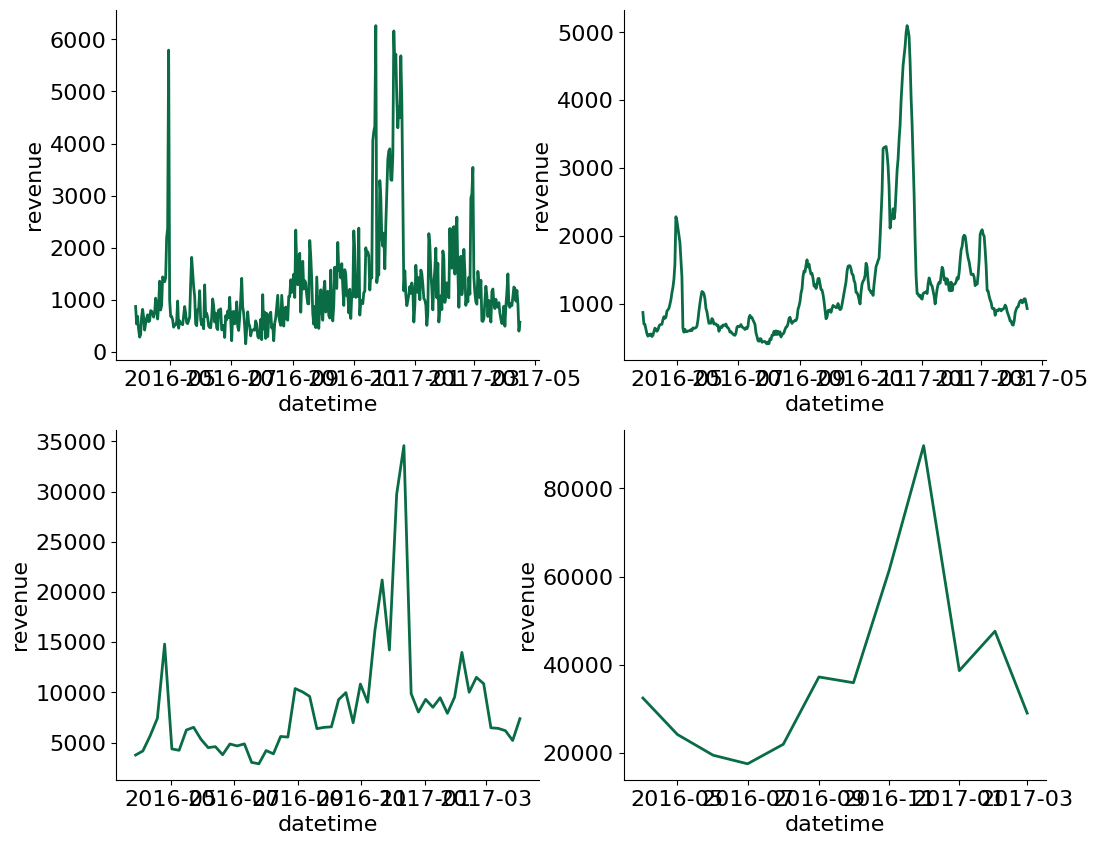

In [21]:
fig, ax = plt.subplots(2,2,figsize=(12,10))
for i, granularity in enumerate(["daily", "rolling_avg", "weekly", "monthly"]):
    sns.lineplot(dict_granularity[granularity]["revenue"],
                ax=ax[i//2][i%2])

## 3). 2). Decomposition of the revenue

In [22]:
df_decomp = (
df[df["Event type"]=="Sales"].copy(deep=True)
).rename(columns={"Product Price":"price", "Product quantity":"quantity"})

df_decomp["revenue"] = (
    df_decomp["price"] * 
    df_decomp["quantity"]
)

df_decomp["datetime"] = df_decomp["datetime"].dt.date 

df_decomp = (
    df_decomp[[
        "datetime", "Existing client", 
        "Product category", 
        "Environment", "Device UX", "Device OS",
        "Browser family", "User location",
        "revenue"
    ]]
)

dict_decomp = {}

for col in ["User location", "Device UX", "Device OS", "Browser family", "Environment",
           "Product category", "Existing client"]:
    dict_decomp[col] = (
        df_decomp.pivot_table(
            index="datetime",
            values="revenue",
            columns=col,
            aggfunc="sum"
        ).add_prefix(f"decomp_{col}_")
    )

    dict_decomp[col].index = (
        pd.to_datetime(dict_decomp[col].index)
    )

    dict_decomp[col] = (
        dict_decomp[col].resample("MS").sum()
    )

# We merge the different ventilations to get contributions
df_decomp_all = (
reduce(lambda left, right: pd.merge(left,
                                   right,
                                   left_index=True,
                                   right_index=True,
                                   how="outer"),
      list(dict_decomp.values()))
)

df_decomp = df_decomp[["datetime", "revenue"]].set_index("datetime")
df_decomp.index = pd.to_datetime(df_decomp.index)
df_decomp = df_decomp.resample("MS").sum()

df_decomp_all = (
    df_decomp_all.merge(df_decomp,
                        left_index=True,
                        right_index=True,
                        how="inner")
)

df_decomp_all.head()

,decomp_User location_Inland,decomp_User location_Outside,decomp_User location_Unknown,decomp_Device UX_Desktop,decomp_Device UX_Smartphone/Tablet,decomp_Device OS_Android,decomp_Device OS_Desktop,decomp_Device OS_Unknown,decomp_Device OS_iOS,decomp_Browser family_applemail,decomp_Browser family_blackberry webkit,decomp_Browser family_chrome,decomp_Browser family_chrome mobile,decomp_Browser family_chrome mobile ios,decomp_Browser family_chromium,decomp_Browser family_edge,decomp_Browser family_edge mobile,decomp_Browser family_facebook,decomp_Browser family_firefox,decomp_Browser family_firefox mobile,decomp_Browser family_ie,decomp_Browser family_ie mobile,decomp_Browser family_iron,decomp_Browser family_maxthon,decomp_Browser family_mobile safari,decomp_Browser family_mobile safari uiwebview,decomp_Browser family_opera,decomp_Browser family_other,decomp_Browser family_safari,decomp_Browser family_sleipnir,decomp_Browser family_unknown,decomp_Environment_Desktop Web,decomp_Environment_Mobile Web,decomp_Environment_app_android,decomp_Product category_Large Items,decomp_Product category_Medium Items,decomp_Product category_Packages,decomp_Product category_Small Items,decomp_Existing client_0,decomp_Existing client_1,revenue
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-03-01,2446.0,71.0,0.0,2360.0,157.0,35.0,2360.0,0.0,122.0,0.0,0.0,1096.0,19.0,0.0,0.0,64.0,0.0,0.0,376.0,0.0,102.0,0.0,0.0,0.0,122.0,0.0,0.0,0.0,738.0,0.0,0.0,2360.0,157.0,0.0,168.0,215.0,1068.0,1066.0,1823.0,694.0,2517.0
2016-04-01,30543.0,1907.0,18.0,30493.0,1975.0,628.0,30493.0,11.0,1336.0,0.0,0.0,12880.0,521.0,35.0,0.0,660.0,0.0,0.0,6734.0,0.0,1880.0,11.0,0.0,0.0,1301.0,0.0,70.0,0.0,8168.0,0.0,186.0,30493.0,1975.0,0.0,2584.0,4319.0,15186.0,10379.0,21367.0,11101.0,32468.0
2016-05-01,22151.0,2050.0,0.0,21461.0,2740.0,523.0,21461.0,781.0,1436.0,0.0,0.0,11272.0,430.0,44.0,11.0,735.0,0.0,18.0,4311.0,0.0,1117.0,0.0,0.0,78.0,1392.0,0.0,12.0,0.0,4616.0,116.0,40.0,21461.0,2740.0,0.0,1985.0,6998.0,8049.0,7169.0,19792.0,4409.0,24201.0
2016-06-01,18308.0,1196.0,0.0,17446.0,2058.0,546.0,17446.0,32.0,1480.0,0.0,0.0,8682.0,417.0,11.0,54.0,851.0,0.0,32.0,2591.0,0.0,965.0,0.0,0.0,0.0,1469.0,0.0,25.0,0.0,4383.0,0.0,24.0,17446.0,2058.0,0.0,989.0,4031.0,8014.0,6470.0,15732.0,3772.0,19504.0
2016-07-01,15934.0,1618.0,0.0,15873.0,1679.0,324.0,15873.0,16.0,1339.0,0.0,0.0,7323.0,292.0,45.0,14.0,720.0,0.0,16.0,3014.0,12.0,540.0,0.0,0.0,0.0,1265.0,29.0,0.0,0.0,4233.0,0.0,49.0,15873.0,1679.0,0.0,1100.0,2427.0,8102.0,5923.0,14322.0,3230.0,17552.0


findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

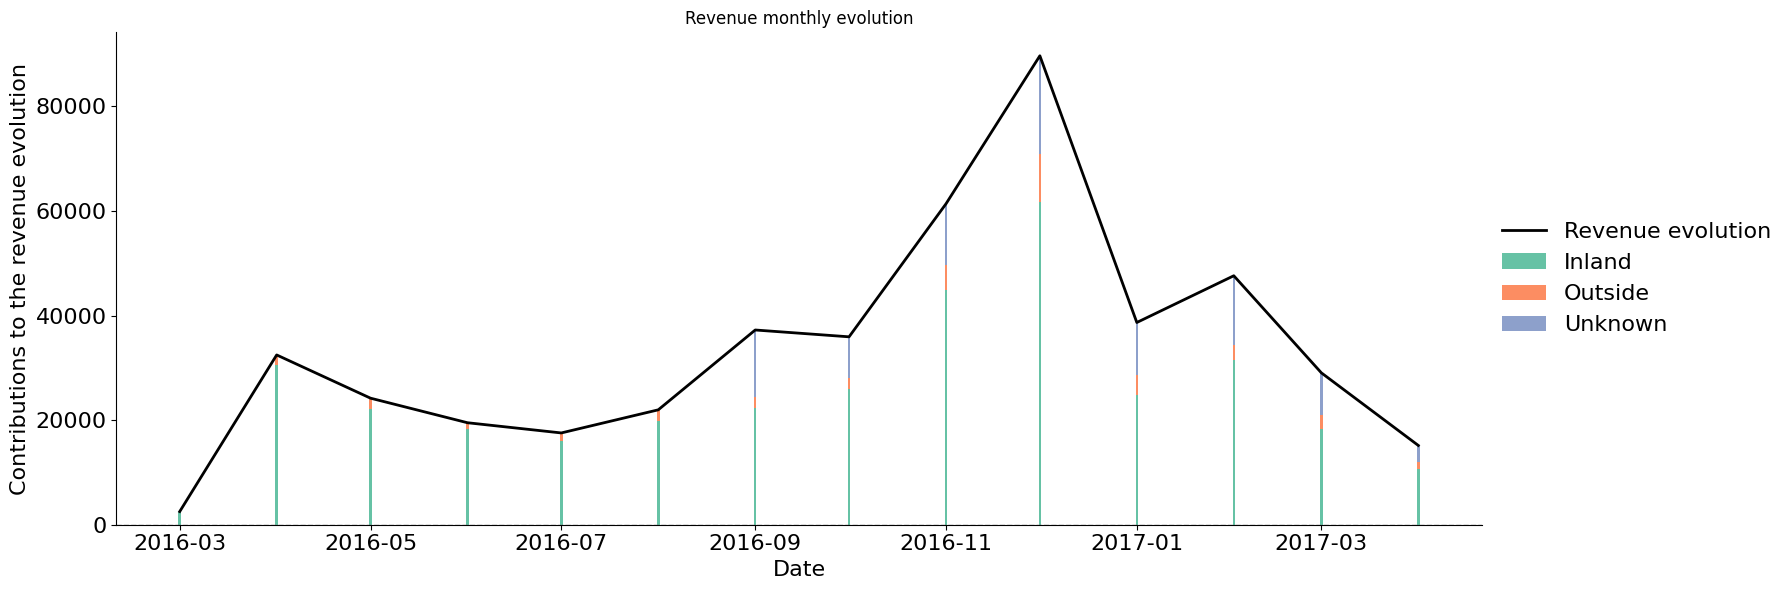

In [23]:
plot_contributions(df_decomp_all, 
                   "revenue", 
                   [col for col in df_decomp_all.columns
                   if col.startswith("decomp_User location")])

findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

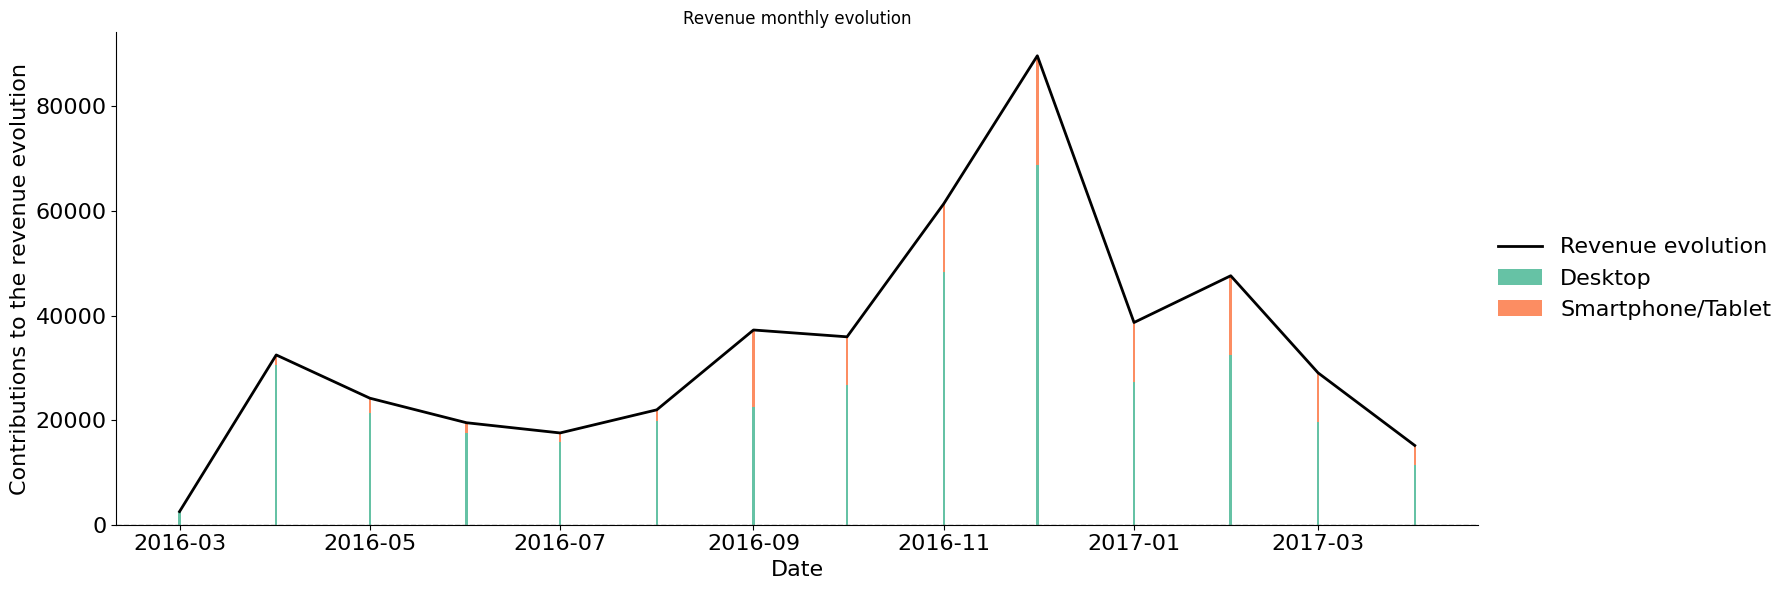

In [24]:
plot_contributions(df_decomp_all, 
                   "revenue", 
                   [col for col in df_decomp_all.columns
                   if col.startswith("decomp_Device UX")])

findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

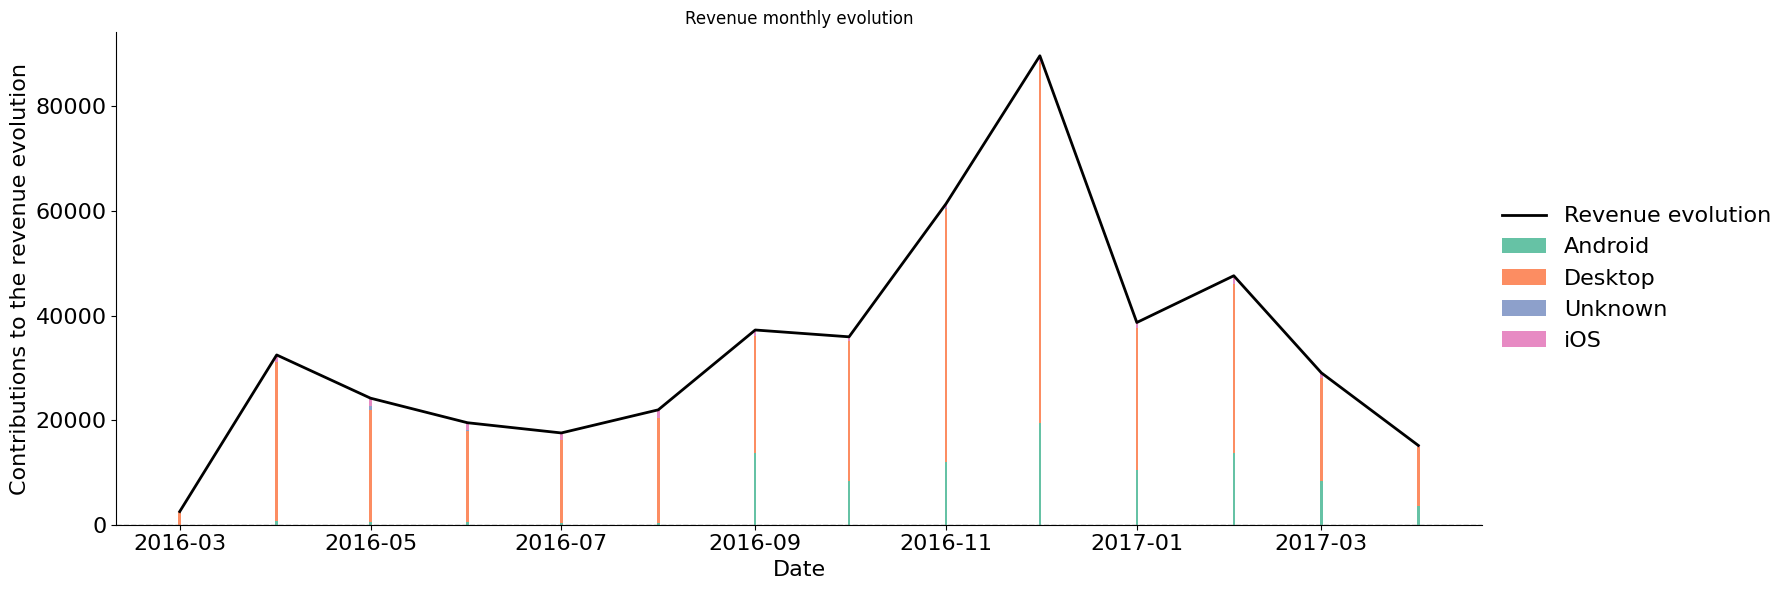

In [25]:
plot_contributions(df_decomp_all, 
                   "revenue", 
                   [col for col in df_decomp_all.columns
                   if col.startswith("decomp_Device OS")])

findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

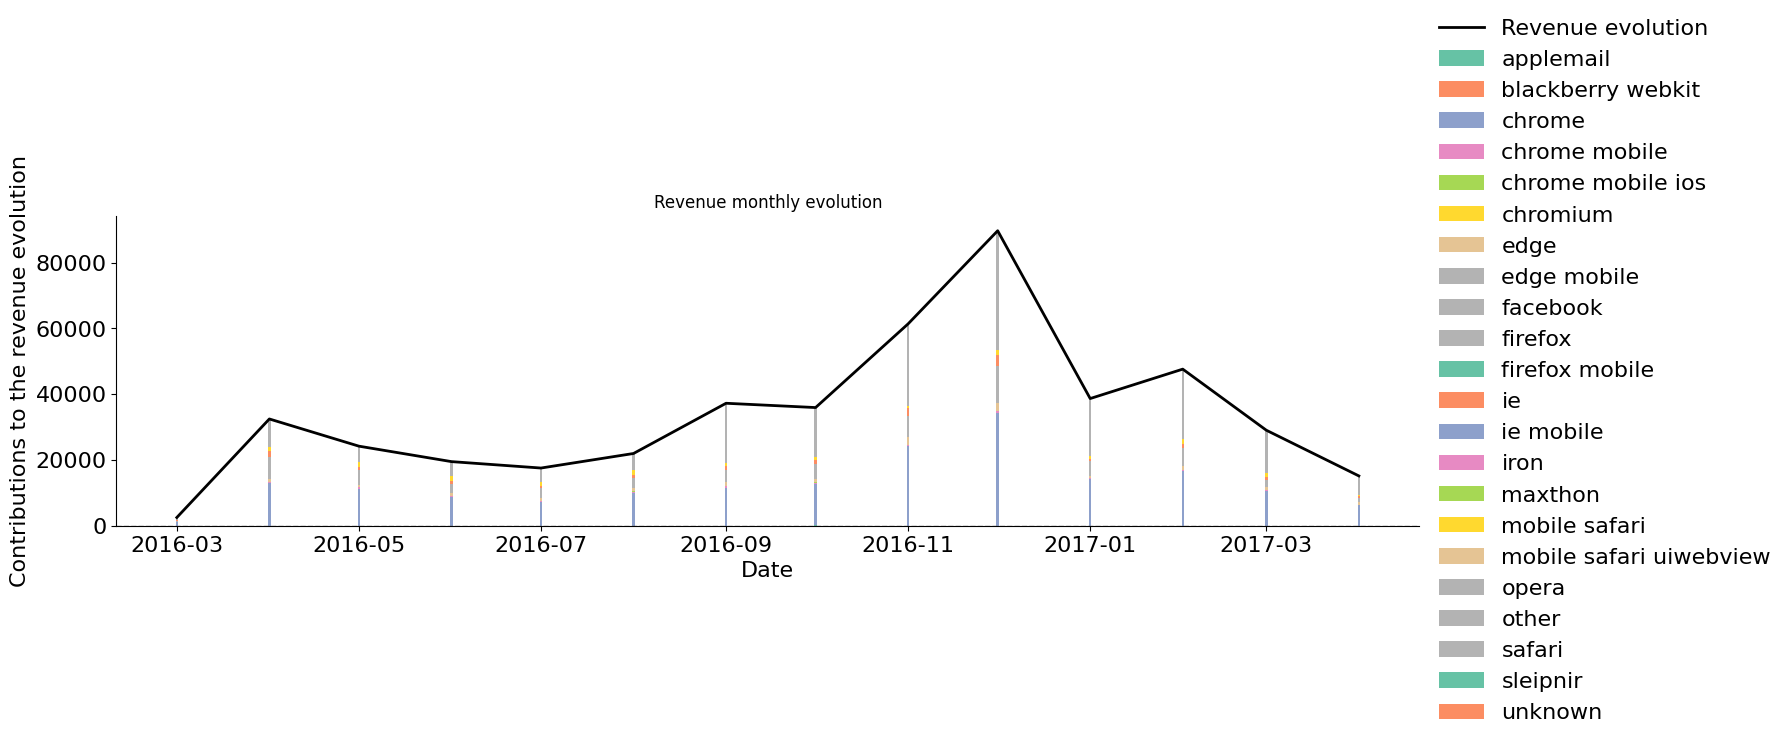

In [26]:
plot_contributions(df_decomp_all, 
                   "revenue", 
                   [col for col in df_decomp_all.columns
                   if col.startswith("decomp_Browser family")])

findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

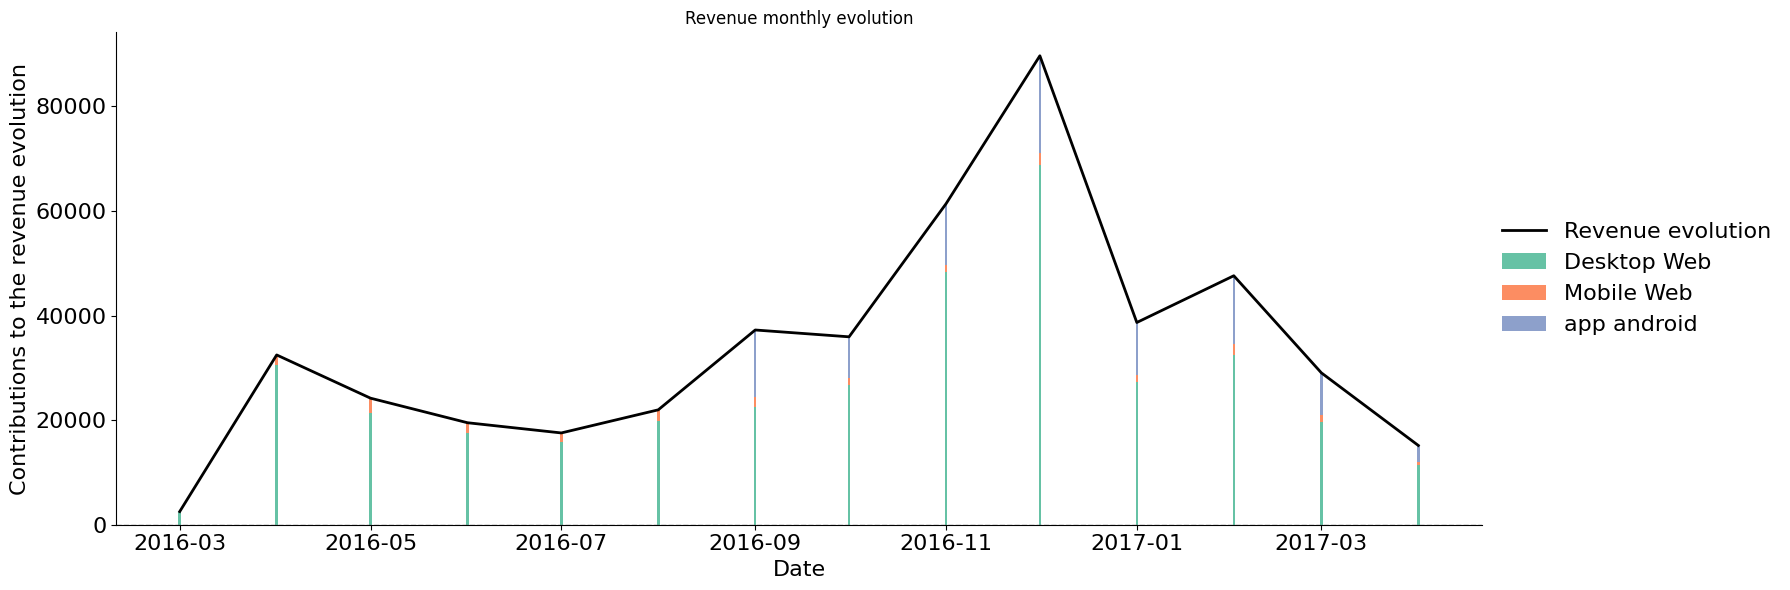

In [27]:
plot_contributions(df_decomp_all, 
                   "revenue", 
                   [col for col in df_decomp_all.columns
                   if col.startswith("decomp_Environment")])

findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

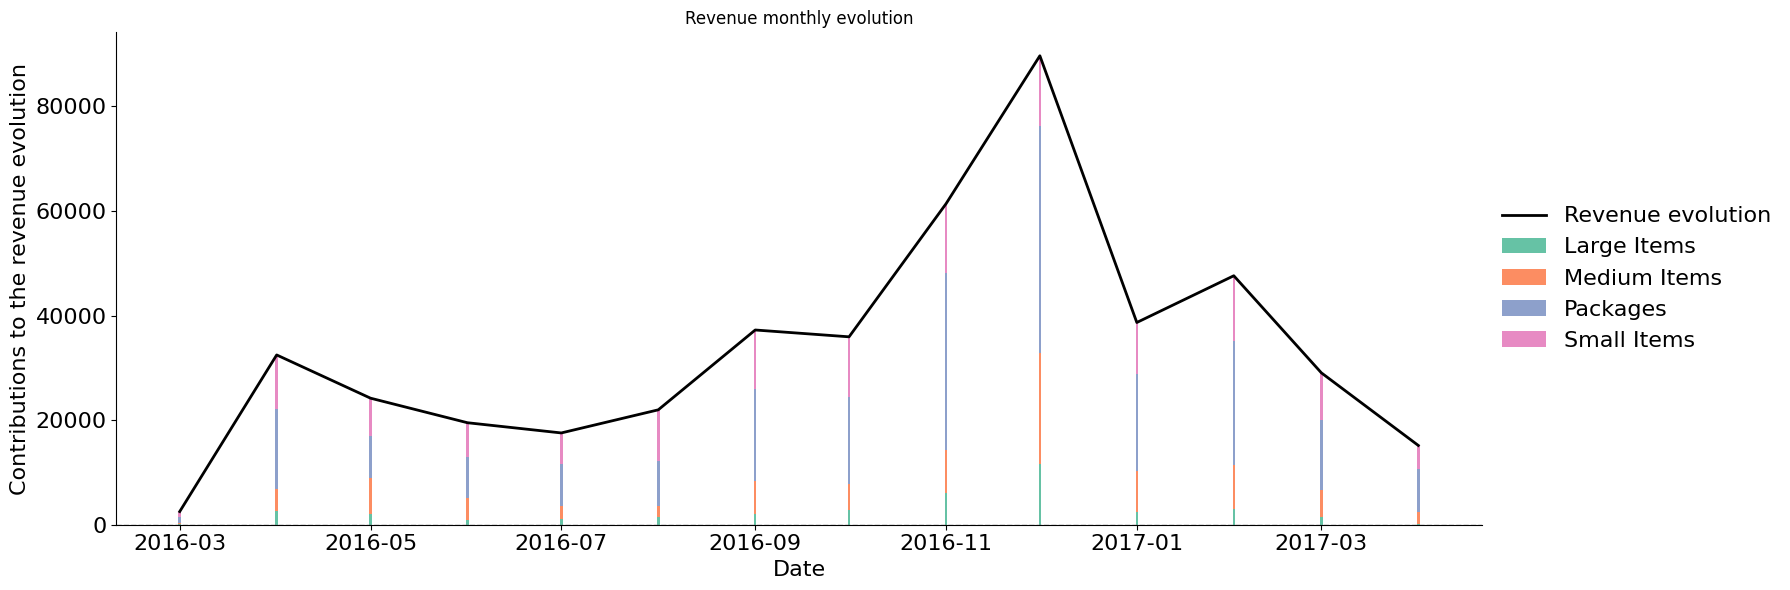

In [28]:
plot_contributions(df_decomp_all, 
                   "revenue", 
                   [col for col in df_decomp_all.columns
                   if col.startswith("decomp_Product category")])

findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

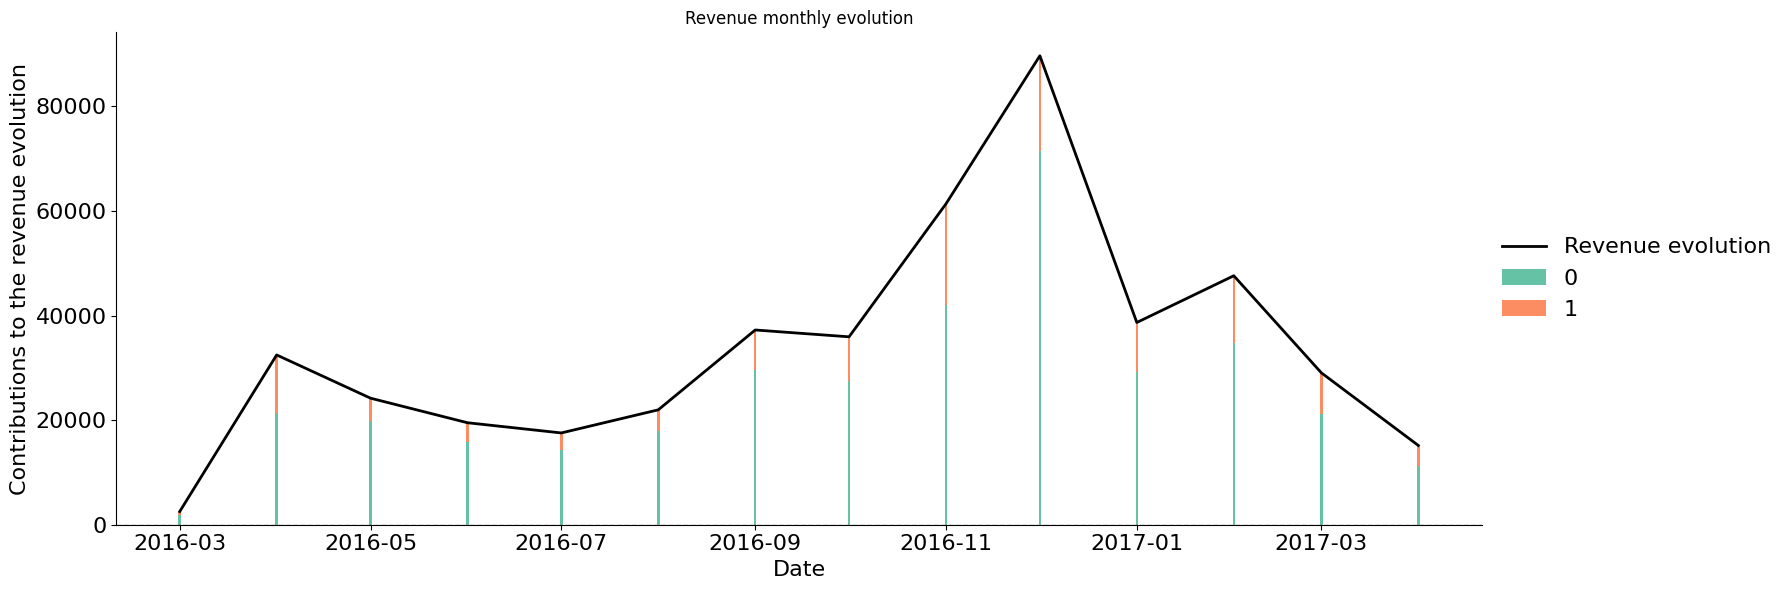

In [29]:
plot_contributions(df_decomp_all, 
                   "revenue", 
                   [col for col in df_decomp_all.columns
                   if col.startswith("decomp_Existing client")])

## 3). 3). Distributions

findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

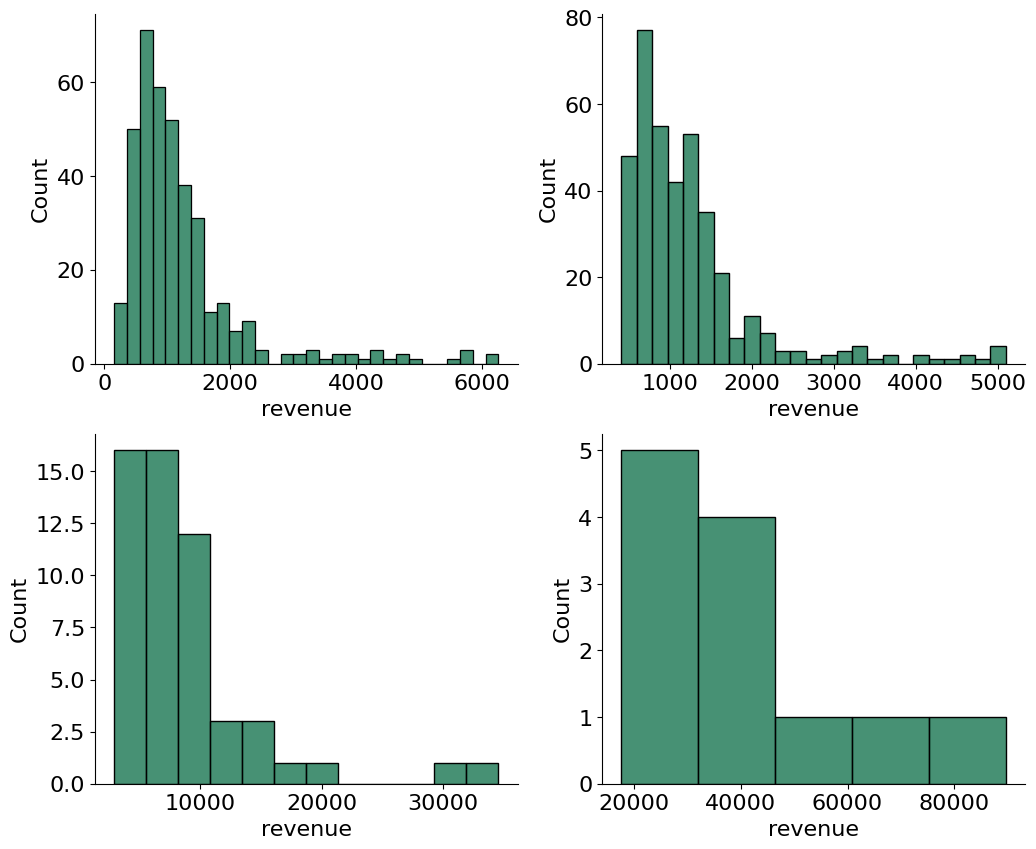

In [30]:
fig, ax = plt.subplots(2,2,figsize=(12,10))
for i, granularity in enumerate(["daily", "rolling_avg", "weekly", "monthly"]):
    sns.histplot(dict_granularity[granularity]["revenue"],
                ax=ax[i//2][i%2])

## 3). 4). STL decomposition

findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

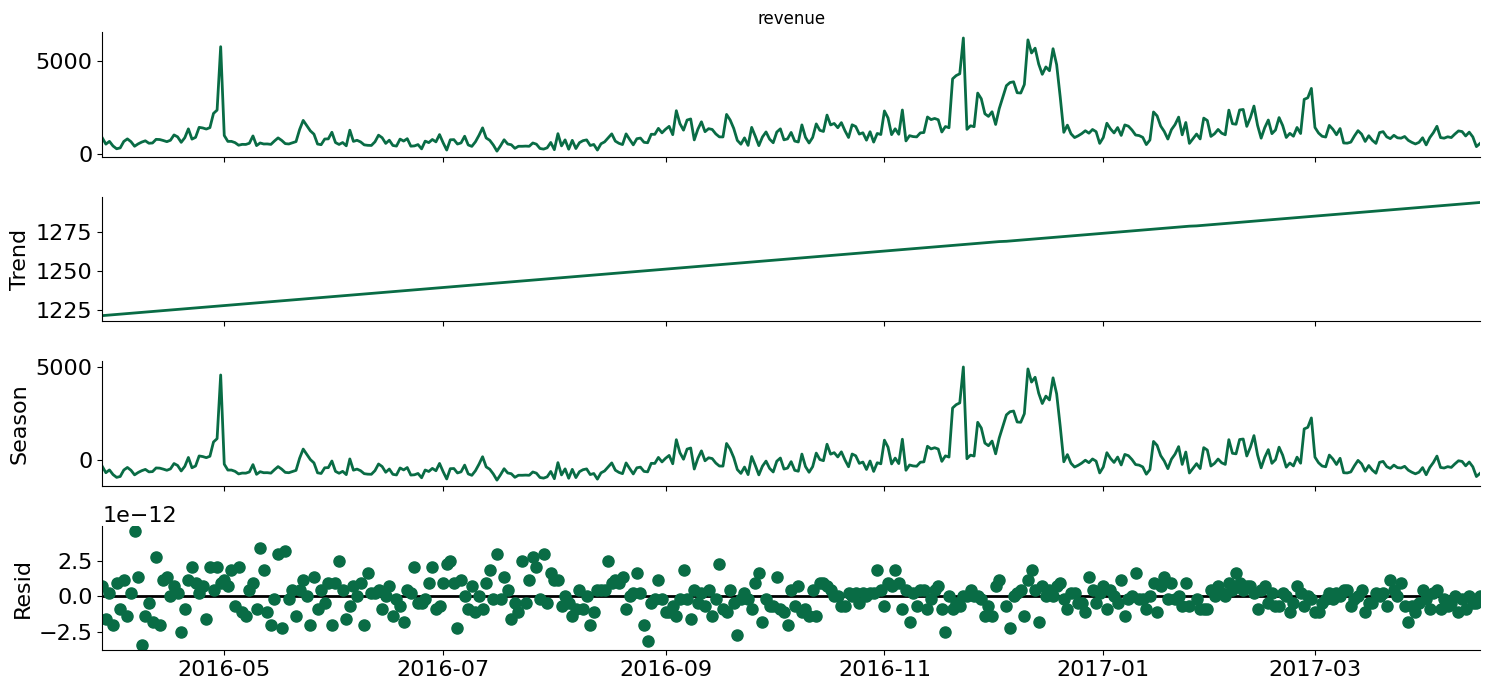

In [31]:
stl = STL(dict_granularity["daily"]["revenue"].dropna(how="any"),
         period=dict_periods["daily"])
result=stl.fit()
result.plot()
plt.tight_layout()

findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

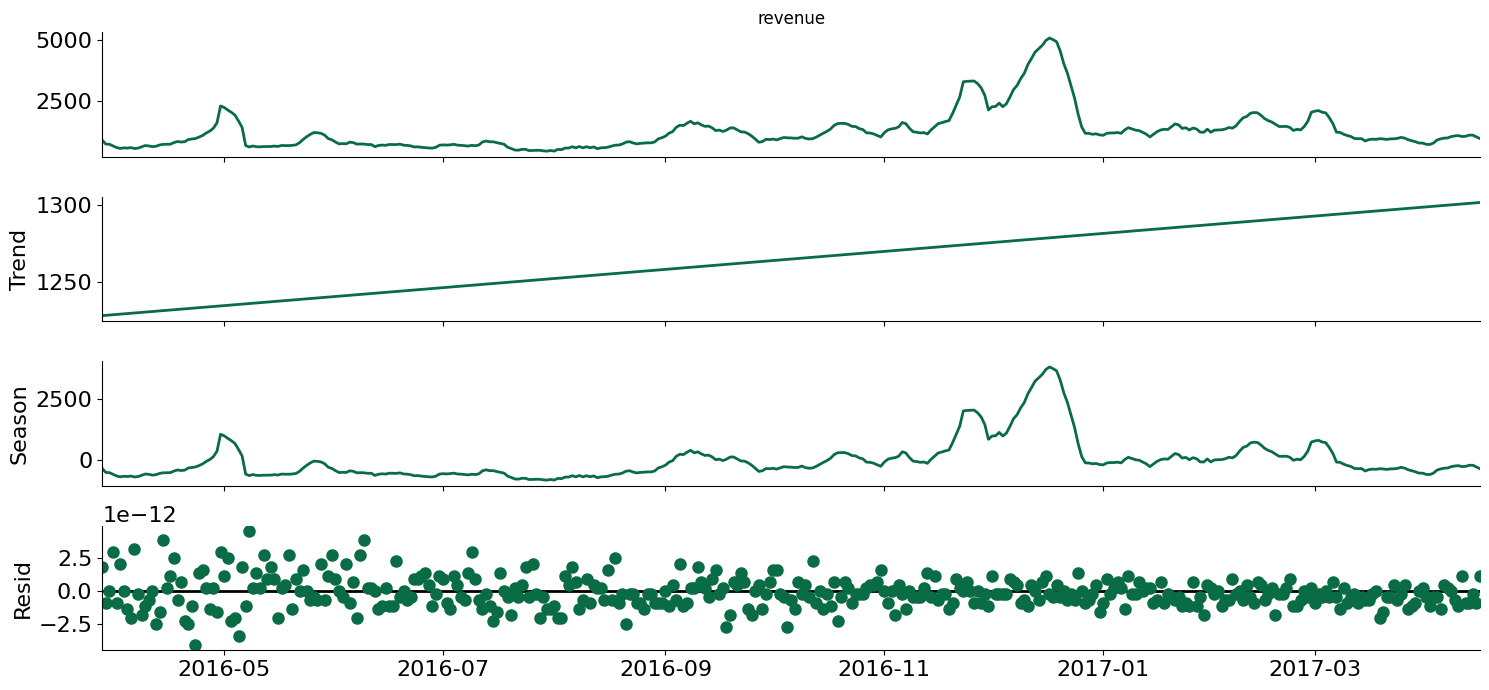

In [32]:
stl = STL(dict_granularity["rolling_avg"]["revenue"],
         period=dict_periods["rolling_avg"])
result=stl.fit()
result.plot()
plt.tight_layout()

findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

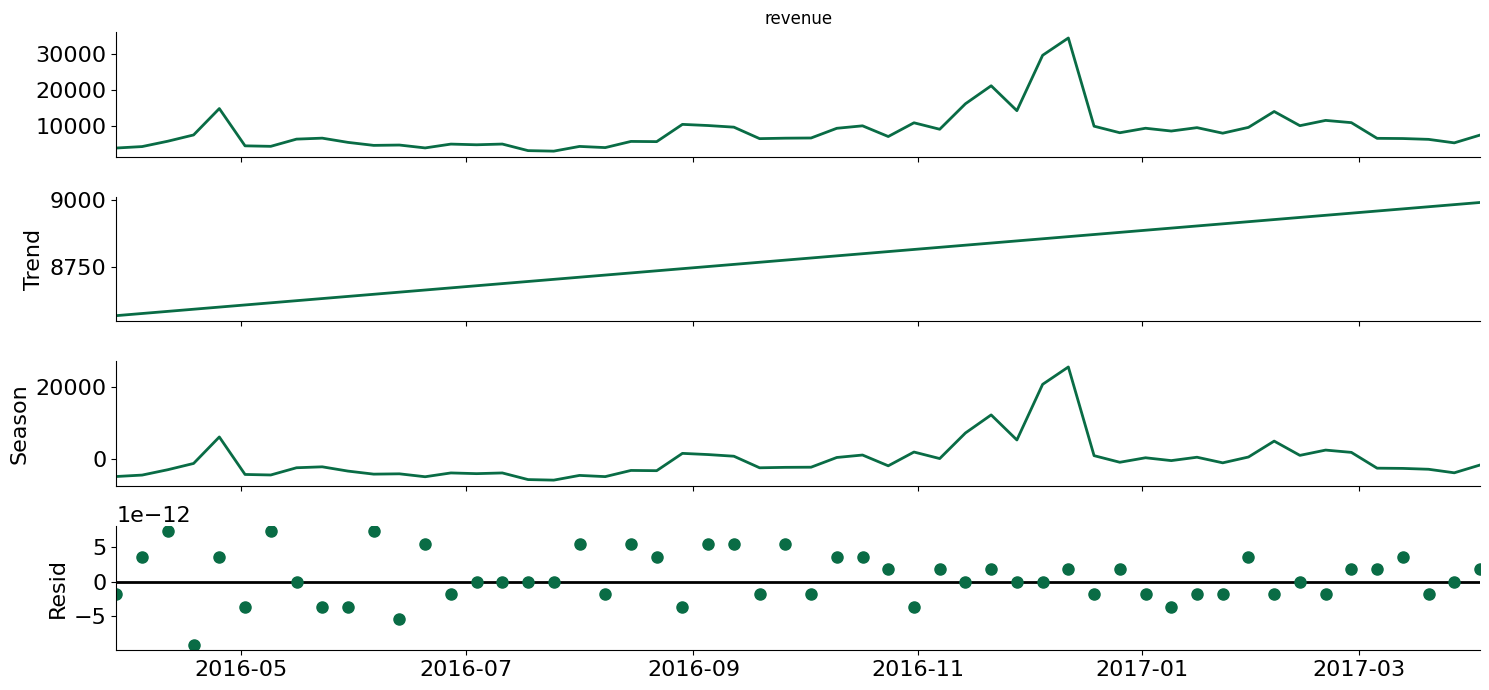

In [33]:
stl = STL(dict_granularity["weekly"]["revenue"],
         period=dict_periods["weekly"])
result=stl.fit()
result.plot()
plt.tight_layout()

We choose weekly data or rolling average for findings trends and seasonality as its a tradeoff between smoothing week days vs. week ends dynamics and noise and giving more data points than monthly data that has for 1.5 years too few noise

## 3). 5). Weekly evolutions

<Axes: xlabel='datetime'>

findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

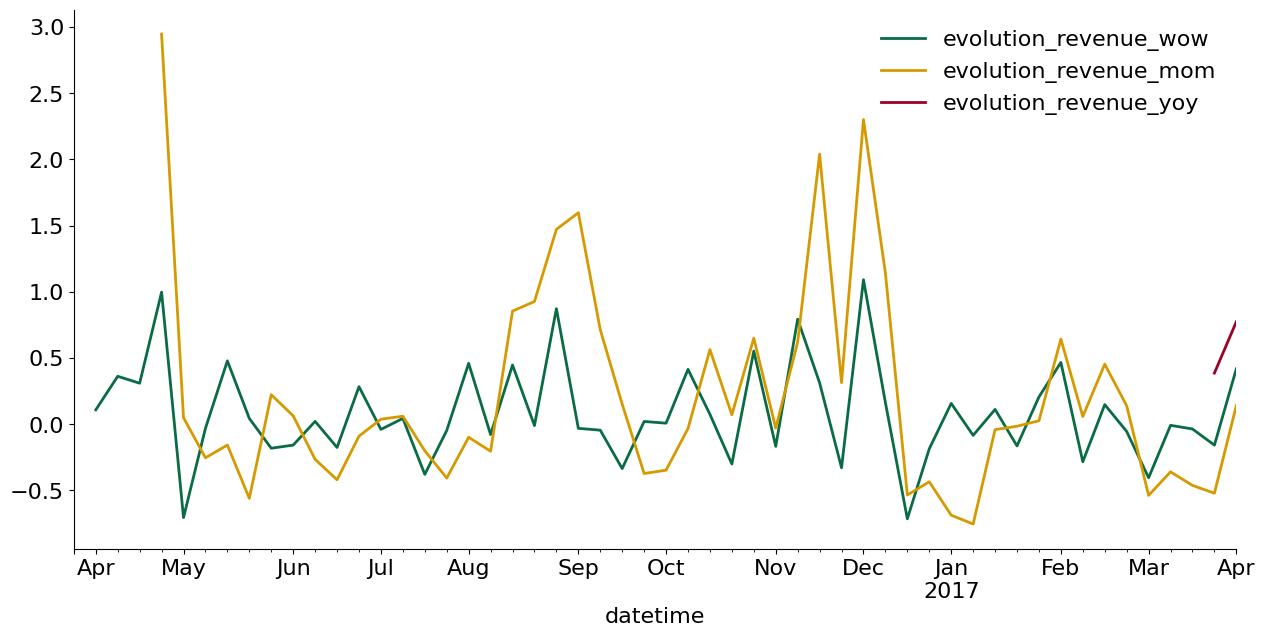

In [34]:
df_revenues_weekly["evolution_revenue_wow"]  =(
    df_revenues_weekly["revenue"].pct_change()
)

df_revenues_weekly["evolution_revenue_mom"]  =(
    df_revenues_weekly["revenue"].pct_change(periods=4)
)

df_revenues_weekly["evolution_revenue_yoy"]  =(
    df_revenues_weekly["revenue"].pct_change(periods=52)
)

df_revenues_weekly[["evolution_revenue_wow",
                   "evolution_revenue_mom",
                   "evolution_revenue_yoy"]].plot()

findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

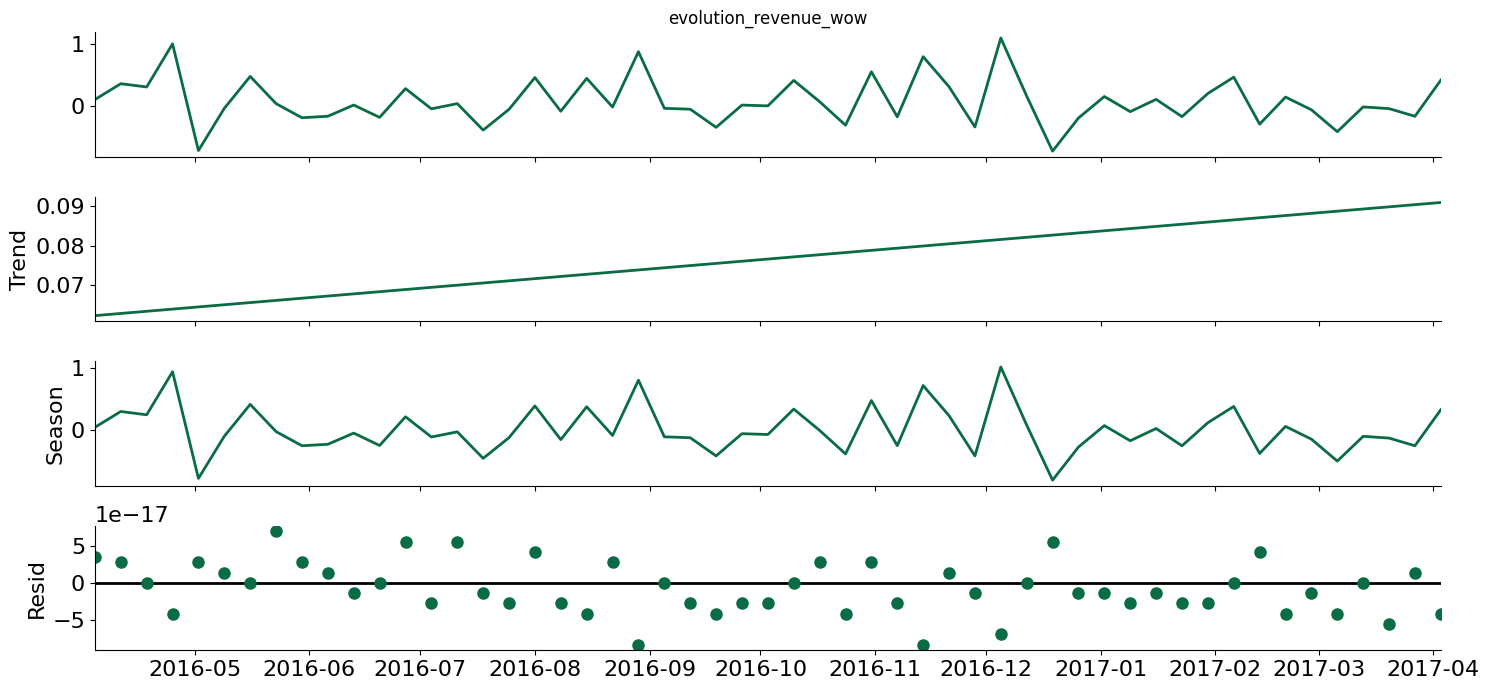

In [35]:
stl = STL(df_revenues_weekly["evolution_revenue_wow"].dropna(how="any"),
         period=dict_periods["weekly"])
result=stl.fit()
result.plot()
plt.tight_layout()

findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

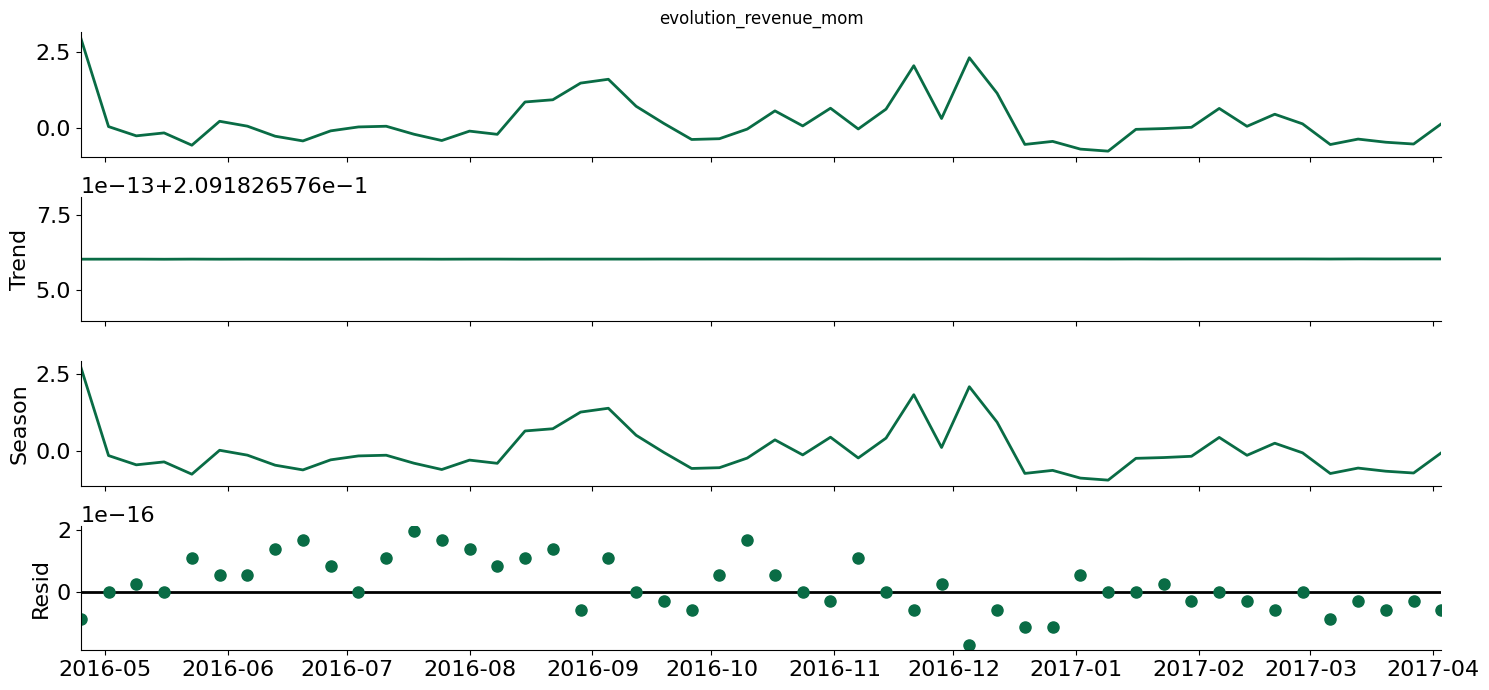

In [36]:
stl = STL(df_revenues_weekly["evolution_revenue_mom"].dropna(how="any"),
         period=dict_periods["weekly"])
result=stl.fit()
result.plot()
plt.tight_layout()

In [37]:
print(f"Average WoW rate for weekly revenue: {average_rate(df_revenues_weekly["evolution_revenue_wow"].dropna())*100} %")
print(f"Average MoM rate for weekly revenue: {average_rate(df_revenues_weekly["evolution_revenue_mom"].dropna())*100} %")

Average WoW rate for weekly revenue: 7.956564185197634 %
Average MoM rate for weekly revenue: 9.059415030111717 %


<Axes: xlabel='evolution_revenue_mom', ylabel='Count'>

findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

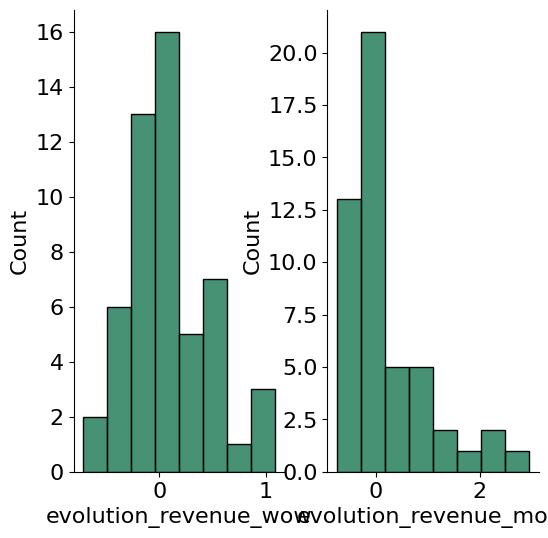

In [38]:
fig, ax = plt.subplots(1,2,figsize=(6,6))

sns.histplot(df_revenues_weekly["evolution_revenue_wow"], ax=ax[0])
sns.histplot(df_revenues_weekly["evolution_revenue_mom"], ax=ax[1])

## 3). 6). Contributions to the monthly evolutions

In [39]:
df_contrib = (
df[df["Event type"]=="Sales"].copy(deep=True)
).rename(columns={"Product Price":"price", "Product quantity":"quantity"})

df_contrib["revenue"] = (
    df_contrib["price"] * 
    df_contrib["quantity"]
)

df_contrib["datetime"] = df_contrib["datetime"].dt.date

df_contrib = (
    df_contrib[["datetime", "revenue", "User location", "Device UX", "Device OS", "Browser family", 
               "Environment", "Product category", "Existing client"]]
)

dict_contrib = {}

for col in ["User location", "Device UX", "Device OS", "Browser family", "Environment",
           "Product category", "Existing client"]:
    dict_contrib[col] = (
        df_contrib.pivot_table(
            index="datetime",
            values="revenue",
            columns=col,
            aggfunc="sum"
        ).add_prefix(f"{col}_")
    )

    dict_contrib[col].index = (
        pd.to_datetime(dict_contrib[col].index)
    )


    dict_contrib[col] = (
        dict_contrib[col].resample("MS").sum()
    )

# We merge the different ventilations to get contributions
df_contrib_all = (
reduce(lambda left, right: pd.merge(left,
                                   right,
                                   left_index=True,
                                   right_index=True,
                                   how="outer"),
      list(dict_contrib.values()))
)

df_contrib = df_contrib[["datetime", "revenue"]].set_index("datetime")
df_contrib.index = pd.to_datetime(df_contrib.index)
df_contrib = df_contrib.resample("MS").sum()
df_contrib = df_contrib.iloc[1:-1]

df_contrib_all = (
    df_contrib_all.merge(df_contrib,
                        left_index=True,
                        right_index=True,
                        how="inner")
)

#We compute the contributions
for col in ["User location", "Device UX", "Device OS", "Browser family", 
            "Environment","Product category", "Existing client"]:
    for col_ in [_ for _ in df_contrib_all.columns
                if _.startswith(col)]:

        df_contrib_all[f"contrib_{col_}"] = (
            # df_contrib_all[col_].shift(1)/df_contrib_all["revenue"].shift(1)
            # *df_contrib_all[col_].pct_change()
            df_contrib_all[col_].diff(1)/df_contrib_all["revenue"].shift(1)
        )

df_contrib_all["evolution_revenue"] = (
    df_contrib_all["revenue"].pct_change()
)

df_contrib_all = (
    df_contrib_all[[col for col in df_contrib_all.columns
                   if col.startswith("contrib_") or col.startswith("evolution_")]]
)

df_contrib_all.head()

,contrib_User location_Inland,contrib_User location_Outside,contrib_User location_Unknown,contrib_Device UX_Desktop,contrib_Device UX_Smartphone/Tablet,contrib_Device OS_Android,contrib_Device OS_Desktop,contrib_Device OS_Unknown,contrib_Device OS_iOS,contrib_Browser family_applemail,contrib_Browser family_blackberry webkit,contrib_Browser family_chrome,contrib_Browser family_chrome mobile,contrib_Browser family_chrome mobile ios,contrib_Browser family_chromium,contrib_Browser family_edge,contrib_Browser family_edge mobile,contrib_Browser family_facebook,contrib_Browser family_firefox,contrib_Browser family_firefox mobile,contrib_Browser family_ie,contrib_Browser family_ie mobile,contrib_Browser family_iron,contrib_Browser family_maxthon,contrib_Browser family_mobile safari,contrib_Browser family_mobile safari uiwebview,contrib_Browser family_opera,contrib_Browser family_other,contrib_Browser family_safari,contrib_Browser family_sleipnir,contrib_Browser family_unknown,contrib_Environment_Desktop Web,contrib_Environment_Mobile Web,contrib_Environment_app_android,contrib_Product category_Large Items,contrib_Product category_Medium Items,contrib_Product category_Packages,contrib_Product category_Small Items,contrib_Existing client_0,contrib_Existing client_1,evolution_revenue
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-01,-0.258470,0.004404,-0.000554,-0.278182,0.023562,-0.003234,-0.278182,0.023716,0.003080,0.0,0.0,-0.049526,-0.002803,0.000277,0.000339,0.002310,0.000000,0.000554,-0.074627,0.000000,-0.023500,-0.000339,0.000000,0.002402,0.002803,0.000000,-0.001786,0.0,-0.109400,0.003573,-0.004497,-0.278182,0.023562,0.0,-0.018449,0.082512,-0.219816,-0.098867,-0.048509,-0.206111,-0.254620
2016-06-01,-0.158795,-0.035288,0.000000,-0.165902,-0.028181,0.000950,-0.165902,-0.030949,0.001818,0.0,0.0,-0.107020,-0.000537,-0.001364,0.001777,0.004793,0.000000,0.000578,-0.071071,0.000000,-0.006281,0.000000,0.000000,-0.003223,0.003182,0.000000,0.000537,0.0,-0.009628,-0.004793,-0.000661,-0.165902,-0.028181,0.0,-0.041155,-0.122598,-0.001446,-0.028883,-0.167762,-0.026321,-0.194083
2016-07-01,-0.121719,0.021637,0.000000,-0.080650,-0.019432,-0.011382,-0.080650,-0.000820,-0.007229,0.0,0.0,-0.069678,-0.006409,0.001743,-0.002051,-0.006717,0.000000,-0.000820,0.021688,0.000615,-0.021790,0.000000,0.000000,0.000000,-0.010459,0.001487,-0.001282,0.0,-0.007691,0.000000,0.001282,-0.080650,-0.019432,0.0,0.005691,-0.082240,0.004512,-0.028046,-0.072293,-0.027789,-0.100082
2016-08-01,0.227666,0.024214,0.000000,0.230971,0.020909,0.004558,0.230971,-0.000285,0.016636,0.0,0.0,0.148530,0.002621,0.008147,0.008603,0.015953,0.000627,-0.000912,-0.007919,-0.000684,0.020112,0.000000,0.000912,0.000000,0.010141,-0.001652,0.001310,0.0,0.046604,0.000000,-0.000513,0.230971,0.020909,0.0,0.024385,-0.022789,0.033500,0.216784,0.203794,0.048086,0.251880


findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

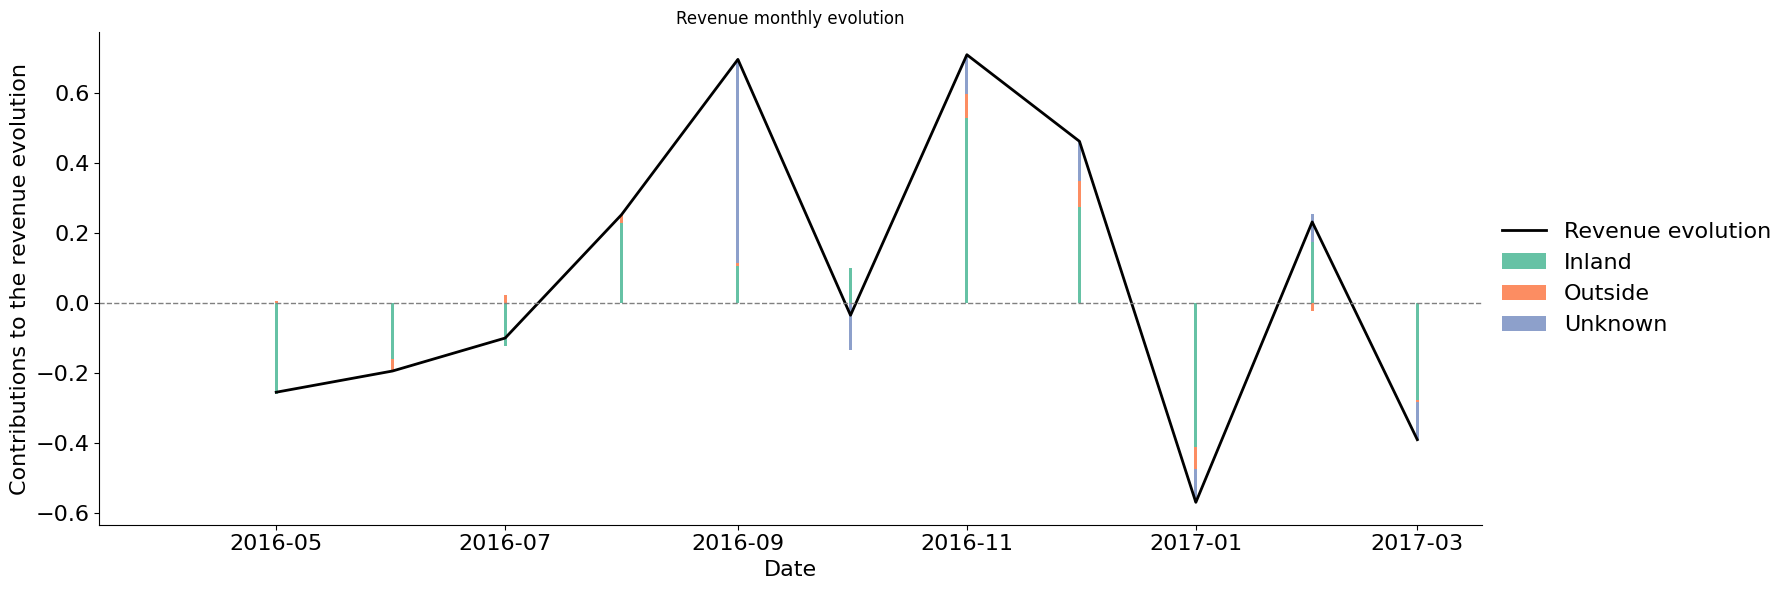

In [40]:
plot_contributions(df_contrib_all, 
                   "evolution_revenue", 
                   [col for col in df_contrib_all.columns
                   if col.startswith("contrib_User location")])

findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

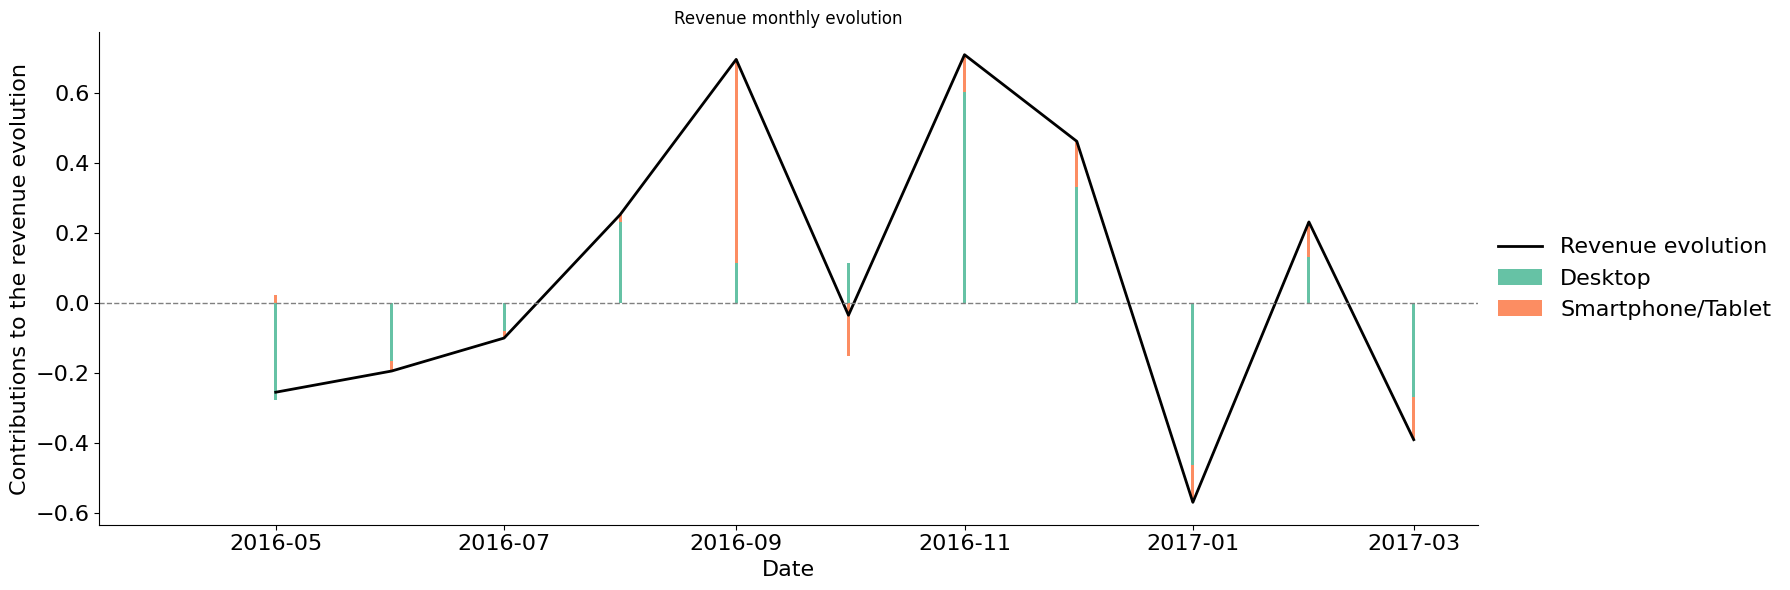

In [41]:
plot_contributions(df_contrib_all, 
                   "evolution_revenue", 
                   [col for col in df_contrib_all.columns
                   if col.startswith("contrib_Device UX")])

findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

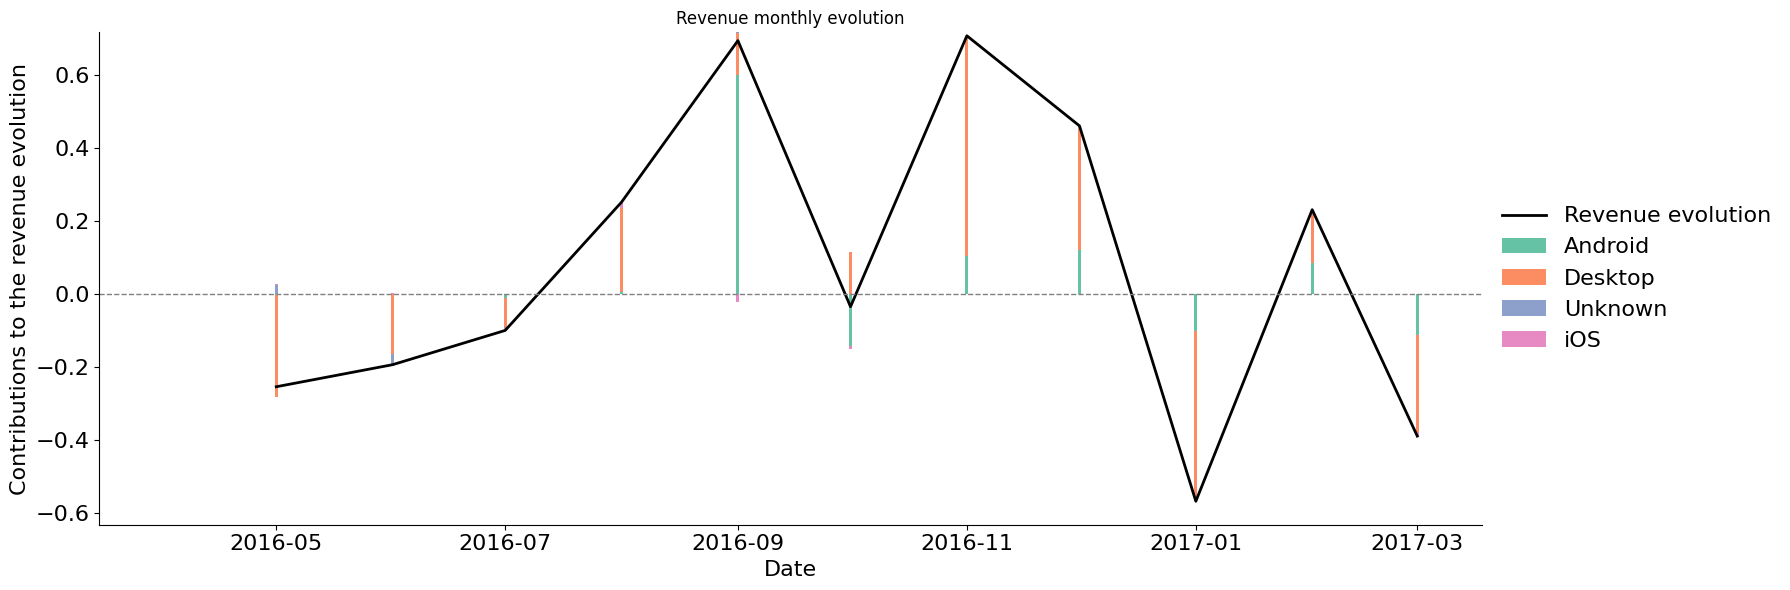

In [42]:
plot_contributions(df_contrib_all, 
                   "evolution_revenue", 
                   [col for col in df_contrib_all.columns
                   if col.startswith("contrib_Device OS")])

findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

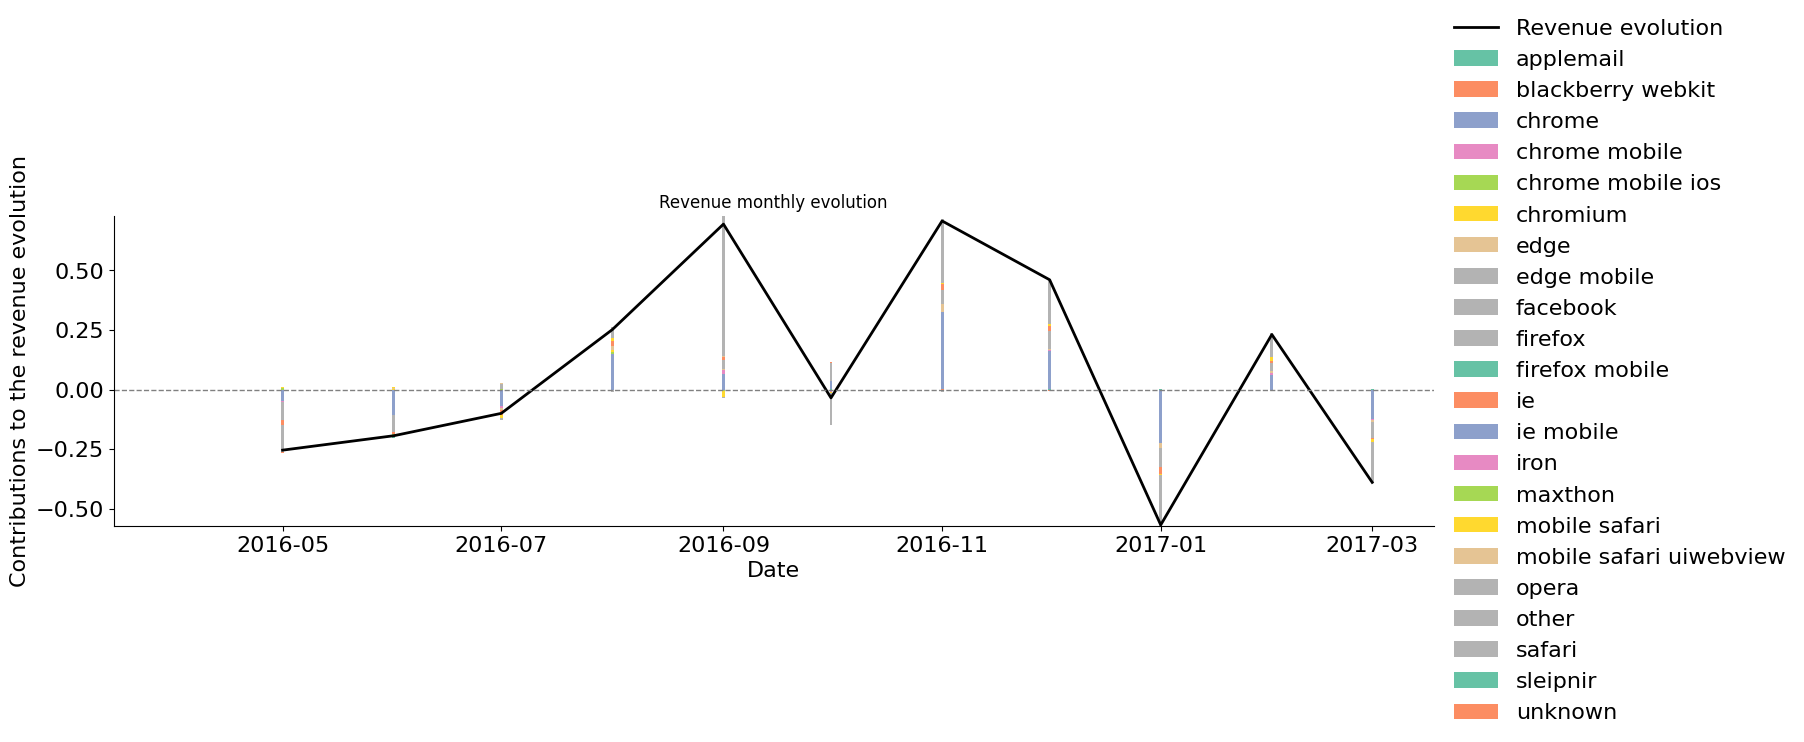

In [43]:
plot_contributions(df_contrib_all, 
                   "evolution_revenue", 
                   [col for col in df_contrib_all.columns
                   if col.startswith("contrib_Browser family")])

findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

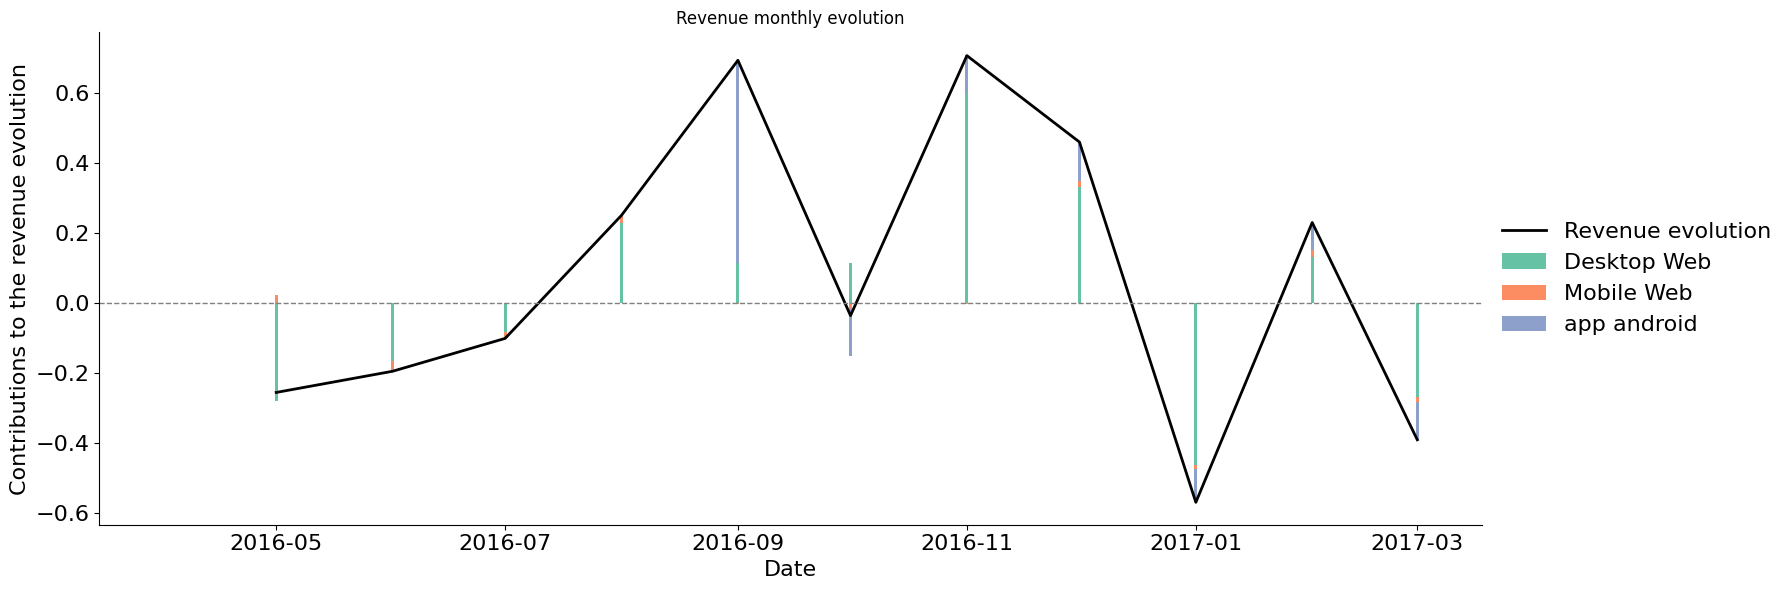

In [44]:
plot_contributions(df_contrib_all, 
                   "evolution_revenue", 
                   [col for col in df_contrib_all.columns
                   if col.startswith("contrib_Environment")])

findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

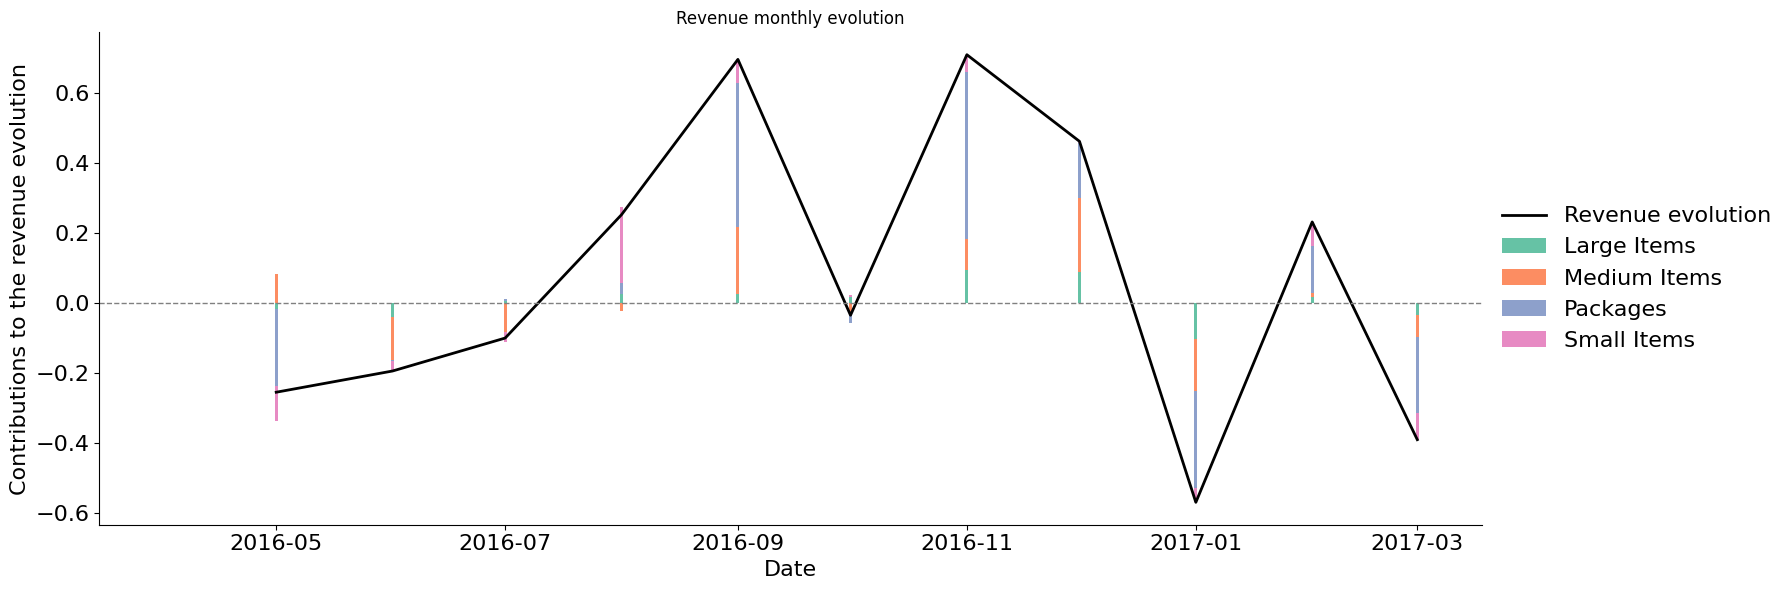

In [45]:
plot_contributions(df_contrib_all, 
                   "evolution_revenue", 
                   [col for col in df_contrib_all.columns
                   if col.startswith("contrib_Product category")])

findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

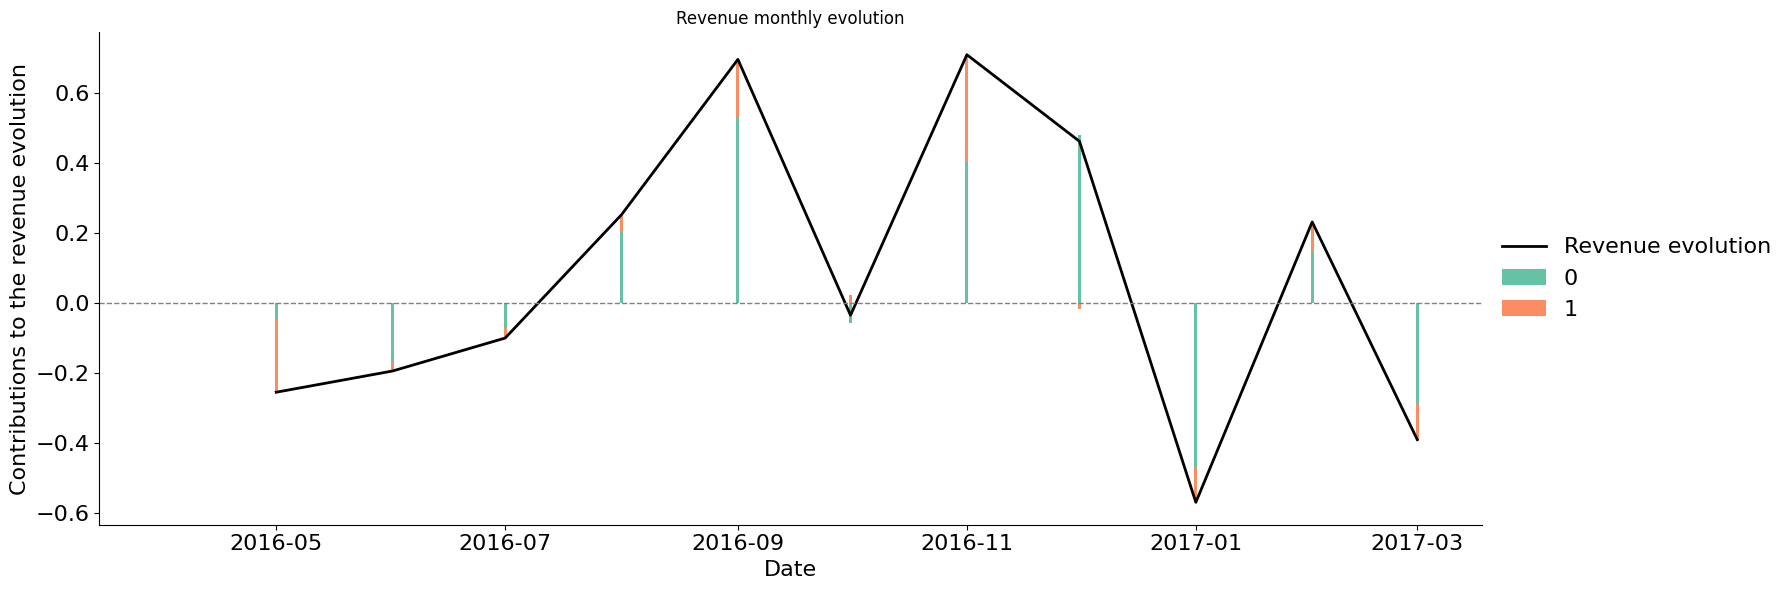

In [46]:
plot_contributions(df_contrib_all, 
                   "evolution_revenue", 
                   [col for col in df_contrib_all.columns
                   if col.startswith("contrib_Existing client")])

## 3). 7). Volume/Price decompositions

In [47]:
# df_pv = (
# df[df["Event type"]=="Sales"].copy(deep=True)
# ).rename(columns={"Product Price":"price", "Product quantity":"quantity"})

# df_pv[["datetime", ""]]

# 4). Detection of outlier days

In [48]:
# Detection of outliers with zscores -> large skew we cannot use this technique
df_revenues["outlier_z_score"] = (
    np.abs((df_revenues["revenue"]-df_revenues["revenue"].mean())/
           df_revenues["revenue"].std()) > 3
)

# Detection of outliers with IQR
q1=df_revenues["revenue"].quantile(.25)
q3=df_revenues["revenue"].quantile(.75)
df_revenues["outlier_iqr"] = (
    (df_revenues["revenue"] < q1-1.5*(q3-q1))|(df_revenues["revenue"] > q3+1.5*(q3-q1))
)

# Detection of outliers with STL decomposition
df_revenues["stl_residuals"] = (
    STL(df_revenues["revenue"].dropna(how="any"),period=365).fit().resid
)
df_revenues["outlier_stl_residuals_z_score"] = (
    np.abs((df_revenues["stl_residuals"]-df_revenues["stl_residuals"].mean())/df_revenues["stl_residuals"].std()) > 3
)

df_revenues

,revenue,outlier_z_score,outlier_iqr,stl_residuals,outlier_stl_residuals_z_score
datetime,,,,,
2016-03-28,871.0,False,False,6.821210e-13,False
2016-03-29,533.0,False,False,-1.591616e-12,False
2016-03-30,682.0,False,False,2.273737e-13,False
2016-03-31,431.0,False,False,-2.046363e-12,False
2016-04-01,282.0,False,False,9.094947e-13,False
...,...,...,...,...,...
2017-04-12,974.0,False,False,-9.094947e-13,False
2017-04-13,1179.0,False,False,0.000000e+00,False
2017-04-14,922.0,False,False,-4.547474e-13,False


findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: F

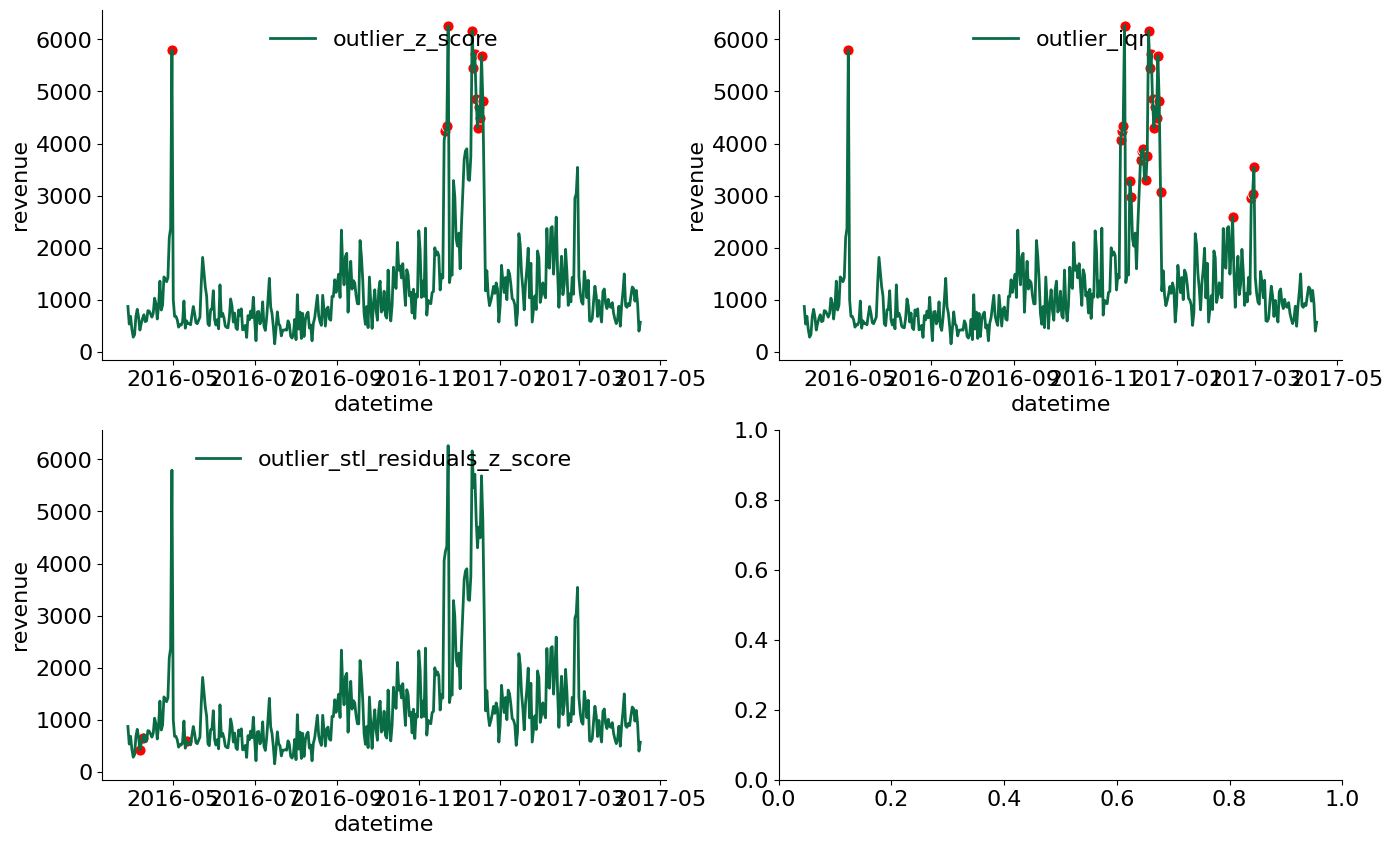

In [49]:
fig, axes = plt.subplots(2,2,figsize=(16,10))
axes = axes.flatten()

for i, outlier in enumerate(["outlier_z_score",
                            "outlier_iqr",
                            "outlier_stl_residuals_z_score"]):

    sns.lineplot(df_revenues, x=df_revenues.index, y="revenue",ax=axes[i],
                label=outlier)
    sns.scatterplot(
        data=df_revenues[df_revenues[outlier]],
        x=df_revenues[df_revenues[outlier]].index,
        y="revenue",
        color="red",
        ax=axes[i]
    )